# Imports

In [1]:
%config IPCompleter.use_jedi = False
%pdb off
# %load_ext viztracer
%load_ext autoreload
%autoreload 2
import sys
import traceback # for stack trace formatting
import importlib
from pathlib import Path
from benedict import benedict
import numpy as np

# required to enable non-blocking interaction:
# %gui qt
# !env QT_API="pyqt5"
%gui qt5
# %gui qt6
# from PyQt5.Qt import QApplication
# # start qt event loop
# _instance = QApplication.instance()
# if not _instance:
#     _instance = QApplication([])
# app = _instance

from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd
from benedict import benedict # https://github.com/fabiocaccamo/python-benedict#usage

# Pho's Formatting Preferences
# from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
# set_pho_preferences_concise()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import CodeConversion
from pyphocorehelpers.print_helpers import print_keys_if_possible, print_value_overview_only, document_active_variables

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat
from neuropy.core.session.Formats.Specific.HiroDataSessionFormat import HiroDataSessionFormatRegisteredClass

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths

# from PendingNotebookCode import _perform_batch_plot, _build_batch_plot_kwargs
from pyphoplacecellanalysis.General.NonInteractiveWrapper import batch_load_session, batch_extended_computations, SessionBatchProgress, batch_programmatic_figures, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme

session_batch_status = {}
session_batch_errors = {}
enable_saving_to_disk = False

global_data_root_parent_path = Path(r'W:\Data') # Windows Apogee
# global_data_root_parent_path = Path(r'/media/MAX/Data') # Diba Lab Workstation Linux
# global_data_root_parent_path = Path(r'/Volumes/MoverNew/data') # rMBP
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"

Automatic pdb calling has been turned OFF
build_module_logger(module_name="Spike3D.pipeline"):
	 Module logger com.PhoHale.Spike3D.pipeline has file logging enabled and will log to EXTERNAL\TESTING\Logging\debug_com.PhoHale.Spike3D.pipeline.log


# Load Pipeline

In [2]:
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

active_data_mode_name = 'kdiba'

## Data must be pre-processed using the MATLAB script located here: 
#     neuropy/data_session_pre_processing_scripts/KDIBA/IIDataMat_Export_ToPython_2022_08_01.m
# From pre-computed .mat files:

local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=self.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('KDIBA')

## Animal `gor01`:
local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='gor01', exper_name='one') # IdentifyingContext<('kdiba', 'gor01', 'one')>
local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name) # 'gor01', 'one'
local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=['PhoHelpers', 'Spike3D-Minimal-Test', 'Unused'])

# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='gor01', exper_name='two')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name)
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=[])

### Animal `vvp01`:
# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='vvp01', exper_name='one')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name)
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=[])

# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='vvp01', exper_name='two')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name)
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=[])

## Build session contexts list:
local_session_contexts_list = [local_session_parent_context.adding_context(collision_prefix='sess', session_name=a_name) for a_name in local_session_names_list] # [IdentifyingContext<('kdiba', 'gor01', 'one', '2006-6-07_11-26-53')>, ..., IdentifyingContext<('kdiba', 'gor01', 'one', '2006-6-13_14-42-6')>]

## Initialize `session_batch_status` with the NOT_STARTED status if it doesn't already have a different status
for curr_session_basedir in local_session_paths_list:
    curr_session_status = session_batch_status.get(curr_session_basedir, None)
    if curr_session_status is None:
        session_batch_status[curr_session_basedir] = SessionBatchProgress.NOT_STARTED # set to not started if not present
        # session_batch_status[curr_session_basedir] = SessionBatchProgress.COMPLETED # set to not started if not present

session_batch_status

local_session_names_list: ['2006-6-07_11-26-53', '2006-6-08_14-26-15', '2006-6-09_1-22-43', '2006-6-09_3-23-37', '2006-6-12_15-55-31', '2006-6-13_14-42-6']


{WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-07_11-26-53'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-08_14-26-15'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-09_3-23-37'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-12_15-55-31'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-13_14-42-6'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>}

In [ ]:
include_programmatic_figures = False # if True, batch_programmatic_figures and batch_extended_programmatic_figures will be ran for each session. Othewise only the computations will be done and the data saved.
batch_saving_mode = PipelineSavingScheme.TEMP_THEN_OVERWRITE
# batch_saving_mode = PipelineSavingScheme.OVERWRITE_IN_PLACE
# batch_saving_mode = PipelineSavingScheme.SKIP_SAVING # useful for just loading the pipelines and doing something with the result (like plotting)

## Run batch queue
for curr_sess_ctx, curr_session_basedir, curr_session_name in zip(local_session_contexts_list, local_session_paths_list, local_session_names_list):
    print(f'curr_session_basedir: {str(curr_session_basedir)}')
    curr_session_status = session_batch_status.get(curr_session_basedir, None)
    if curr_session_status.name != SessionBatchProgress.COMPLETED.name:
        session_batch_status[curr_session_basedir] = SessionBatchProgress.NOT_STARTED
        try:
            session_batch_status[curr_session_basedir] = SessionBatchProgress.RUNNING
            curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, curr_session_basedir, force_reload=True, saving_mode=batch_saving_mode, fail_on_exception=True, skip_extended_batch_computations=False, time_bin_size=0.1)
            # newly_computed_values = batch_extended_computations(curr_active_pipeline, fail_on_exception=True, progress_print=True, debug_print=False) # doing extended batch computations in batch_load_session does not work for some strange reason.
            # if len(newly_computed_values) > 0:
            #         curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.OVERWRITE_IN_PLACE)
                    
            if include_programmatic_figures:
                active_identifying_session_ctx, active_session_figures_out_path, active_out_figures_list = batch_programmatic_figures(curr_active_pipeline)
                batch_extended_programmatic_figures(curr_active_pipeline)
                
            session_batch_status[curr_session_basedir] = SessionBatchProgress.COMPLETED
            session_batch_errors[curr_session_basedir] = None # clear any error entry
            print(f'completed processing for {curr_session_basedir}.') # : {active_identifying_session_ctx}
        except Exception as e:
            tb = traceback.format_exc()
            print(f'ERROR processing {curr_session_basedir} with error {e}\n{tb}')
            session_batch_status[curr_session_basedir] = SessionBatchProgress.ABORTED
            session_batch_errors[curr_session_basedir] = (e, tb)
            # raise e
    else:
        print(f'\t already completed')

print(f'session_batch_status: {session_batch_status}')
print('!!! done running batch !!!')

# Single basedir (non-batch) testing:

In [3]:
# %pdb on
basedir = local_session_paths_list[2] # NOT 3
print(f'basedir: {str(basedir)}')

# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, force_reload=True, skip_extended_batch_computations=False)
# curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, saving_mode=PipelineSavingScheme.SKIP_SAVING, force_reload=False, skip_extended_batch_computations=False, debug_print=True)
# curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, saving_mode=PipelineSavingScheme.SKIP_SAVING, force_reload=True, skip_extended_batch_computations=True) # temp no-save
## SAVE AFTERWARDS!

# curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, saving_mode=PipelineSavingScheme.SKIP_SAVING, force_reload=False, active_pickle_filename='20221214200324-loadedSessPickle.pkl', skip_extended_batch_computations=True)
# curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, saving_mode=PipelineSavingScheme.SKIP_SAVING, force_reload=False, active_pickle_filename='loadedSessPickle - full-good.pkl', skip_extended_batch_computations=True)

basedir: W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43
Skipping loading from pickled file because force_reload == True.
Loading matlab import file results : W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\2006-6-09_1-22-43.epochs_info.mat... done.
Loading matlab import file results : W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\2006-6-09_1-22-43.position_info.mat... done.
Loading matlab import file results : W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\2006-6-09_1-22-43.spikes.mat... 

c:\users\pho\repos\neuropy\neuropy\core\session\Formats\SessionSpecifications.py:140: UserWarning: WARNING: Optional File: W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\2006-6-09_1-22-43.dat does not exist. Continuing without it.
  warnings.warn(f'WARNING: Optional File: {an_optional_filepath} does not exist. Continuing without it.')


done.
Failure loading .position.npy. Must recompute.

Computing linear positions for all active epochs for session... Saving updated position results results : W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\2006-6-09_1-22-43.position.npy... 2006-6-09_1-22-43.position.npy saved
done.
	 force_recompute is True! Forcing recomputation of .interpolated_spike_positions.npy

Computing interpolate_spike_positions columns results : spikes_df... done.
	 Saving updated interpolated spike position results results : W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\2006-6-09_1-22-43.interpolated_spike_positions.npy... 2006-6-09_1-22-43.interpolated_spike_positions.npy saved
done.
Loading matlab import file results : W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\2006-6-09_1-22-43.laps_info.mat... done.
setting laps object.
session.laps loaded successfully!
Loading matlab import file results : W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\2006-6-09_1-22-43.replay_info.mat... done.
session.replays loaded successfully!
Loa

In [ ]:
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_global_functions=True, fail_on_exception=True, progress_print=True, debug_print=False)

### Burst Detection

In [ ]:
global_epoch_name = curr_active_pipeline.active_completed_computation_result_names[-1] # 'maze'
global_results = curr_active_pipeline.computation_results[global_epoch_name]['computed_data']    
curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_spike_burst_detection_computation'], enabled_filter_names=[global_epoch_name], fail_on_exception=True, debug_print=False)
active_burst_info = global_results['burst_detection']
active_burst_intervals = active_burst_info['burst_intervals']
active_burst_intervals

In [ ]:
## Add the burst_detection burst_intervals to the active_2d_plot:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Render2DEventRectanglesHelper import Render2DEventRectanglesHelper
active_burst_info = global_results['burst_detection']
active_burst_intervals = active_burst_info['burst_intervals']
output_display_items = Render2DEventRectanglesHelper.add_event_rectangles(active_2d_plot, active_burst_intervals) # {'interval_rects_item': active_interval_rects_item}
active_interval_rects_item = output_display_items['interval_rects_item']
active_interval_rects_item

In [ ]:
from pyphocorehelpers.print_helpers import print_object_memory_usage

print_object_memory_usage(active_burst_info) # object size: 14.190922 MB

In [ ]:
# global_results.pf1D_dt.restore_from_snapshot(global_results.pf1D_dt.last_t)
global_results.pf1D_dt.reset()

In [ ]:
global_results.pf1D_dt.curr_num_pos_samples_occupancy_map

In [ ]:
test_snapshot = global_results.pf1D_dt.historical_snapshots[0.0]
test_snapshot

In [ ]:
active_identifying_session_ctx, curr_session_figures_out_path, active_out_figures_list = batch_programmatic_figures(curr_active_pipeline)

In [ ]:
batch_extended_programmatic_figures(curr_active_pipeline)

In [ ]:
for a_name, a_result in curr_active_pipeline.computation_results.items():
    print(f'{a_name}')
    a_result.computed_data.pf1D_dt.reset() # clears the snapshots
    print(a_result.computed_data.pf1D_dt.historical_snapshots)

# global_results.extended_stats.relative_entropy_analyses.historical_snapshots
del global_results.extended_stats.relative_entropy_analyses['historical_snapshots']

# global_results.extended_stats.relative_entropy_analyses.snapshot_differences_result_dict
del global_results.extended_stats.relative_entropy_analyses['snapshot_differences_result_dict']

In [ ]:
# %pdb on
# curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.OVERWRITE_IN_PLACE)
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE)

###  Compute Required Global Computations Manually:

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership # for batch_extended_computations
# ==================================================================================================================== #
# Perform missing global computations                                                                                  #
# ==================================================================================================================== #

## Get computed relative entropy measures:
global_epoch_name = curr_active_pipeline.active_completed_computation_result_names[-1] # 'maze'
global_results = curr_active_pipeline.computation_results[global_epoch_name]['computed_data']

## Get existing `pf1D_dt`:
active_pf_1D = global_results.pf1D
active_pf_1D_dt = global_results.pf1D_dt

## firing_rate_trends:
try:
    active_extended_stats = curr_active_pipeline.computation_results[global_epoch_name].computed_data['extended_stats']
    time_binned_pos_df = active_extended_stats['time_binned_position_df']
except (AttributeError, KeyError) as e:
    print(f'encountered error: {e}. Recomputing...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_firing_rate_trends_computation'], enabled_filter_names=[global_epoch_name], fail_on_exception=True, debug_print=False) 
    print(f'\t done.')
    active_extended_stats = curr_active_pipeline.computation_results[global_epoch_name].computed_data['extended_stats']
    time_binned_pos_df = active_extended_stats['time_binned_position_df']
except Exception as e:
    raise e

## relative_entropy_analyses:
try:
    active_relative_entropy_results = active_extended_stats['relative_entropy_analyses']
    post_update_times = active_relative_entropy_results['post_update_times'] # (4152,) = (n_post_update_times,)
    snapshot_differences_result_dict = active_relative_entropy_results['snapshot_differences_result_dict']
    time_intervals = active_relative_entropy_results['time_intervals']
    long_short_rel_entr_curves_frames = active_relative_entropy_results['long_short_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    short_long_rel_entr_curves_frames = active_relative_entropy_results['short_long_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    flat_relative_entropy_results = active_relative_entropy_results['flat_relative_entropy_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_results = active_relative_entropy_results['flat_jensen_shannon_distance_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_across_all_positions = np.sum(flat_jensen_shannon_distance_results, axis=1) # sum across all position bins # (4152,) - (nSnapshots)
    flat_surprise_across_all_positions = np.sum(flat_relative_entropy_results, axis=1) # sum across all position bins # (4152,) - (nSnapshots)
except (AttributeError, KeyError) as e:
    print(f'encountered error: {e}. Recomputing...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_time_dependent_pf_sequential_surprise_computation'], enabled_filter_names=[global_epoch_name], fail_on_exception=True, debug_print=False)
    print(f'\t done.')
    active_relative_entropy_results = active_extended_stats['relative_entropy_analyses']
    post_update_times = active_relative_entropy_results['post_update_times'] # (4152,) = (n_post_update_times,)
    snapshot_differences_result_dict = active_relative_entropy_results['snapshot_differences_result_dict']
    time_intervals = active_relative_entropy_results['time_intervals']
    long_short_rel_entr_curves_frames = active_relative_entropy_results['long_short_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    short_long_rel_entr_curves_frames = active_relative_entropy_results['short_long_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    flat_relative_entropy_results = active_relative_entropy_results['flat_relative_entropy_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_results = active_relative_entropy_results['flat_jensen_shannon_distance_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_across_all_positions = np.sum(np.abs(flat_jensen_shannon_distance_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)
    flat_surprise_across_all_positions = np.sum(np.abs(flat_relative_entropy_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)
except Exception as e:
    raise e
    
    
## jonathan_firing_rate_analysis:
try:
    ## Get global 'jonathan_firing_rate_analysis' results:
    curr_jonathan_firing_rate_analysis = curr_active_pipeline.global_computation_results.computed_data['jonathan_firing_rate_analysis']
    neuron_replay_stats_df, rdf, aclu_to_idx, irdf = curr_jonathan_firing_rate_analysis['neuron_replay_stats_df'], curr_jonathan_firing_rate_analysis['rdf']['rdf'], curr_jonathan_firing_rate_analysis['rdf']['aclu_to_idx'], curr_jonathan_firing_rate_analysis['irdf']['irdf']
except (AttributeError, KeyError) as e:
    print(f'encountered error: {e}. Recomputing...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_jonathan_replay_firing_rate_analyses'], fail_on_exception=False, debug_print=False) 
    print(f'\t done.')
    curr_jonathan_firing_rate_analysis = curr_active_pipeline.global_computation_results.computed_data['jonathan_firing_rate_analysis']
    neuron_replay_stats_df, rdf, aclu_to_idx, irdf = curr_jonathan_firing_rate_analysis['neuron_replay_stats_df'], curr_jonathan_firing_rate_analysis['rdf']['rdf'], curr_jonathan_firing_rate_analysis['rdf']['aclu_to_idx'], curr_jonathan_firing_rate_analysis['irdf']['irdf']
except Exception as e:
    raise e

## short_long_pf_overlap_analyses:
try:
    ## Get global `short_long_pf_overlap_analyses` results:
    short_long_pf_overlap_analyses = curr_active_pipeline.global_computation_results.computed_data.short_long_pf_overlap_analyses
    conv_overlap_dict = short_long_pf_overlap_analyses['conv_overlap_dict']
    conv_overlap_scalars_df = short_long_pf_overlap_analyses['conv_overlap_scalars_df']
    prod_overlap_dict = short_long_pf_overlap_analyses['product_overlap_dict']
    relative_entropy_overlap_dict = short_long_pf_overlap_analyses['relative_entropy_overlap_dict']
    relative_entropy_overlap_scalars_df = short_long_pf_overlap_analyses['relative_entropy_overlap_scalars_df']

except (AttributeError, KeyError) as e:
    print(f'encountered error: {e}. Recomputing...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_short_long_pf_overlap_analyses'], fail_on_exception=False, debug_print=False)
    print(f'\t done.')
    short_long_pf_overlap_analyses = curr_active_pipeline.global_computation_results.computed_data.short_long_pf_overlap_analyses
    conv_overlap_dict = short_long_pf_overlap_analyses['conv_overlap_dict']
    conv_overlap_scalars_df = short_long_pf_overlap_analyses['conv_overlap_scalars_df']
    prod_overlap_dict = short_long_pf_overlap_analyses['product_overlap_dict']
    relative_entropy_overlap_dict = short_long_pf_overlap_analyses['relative_entropy_overlap_dict']
    relative_entropy_overlap_scalars_df = short_long_pf_overlap_analyses['relative_entropy_overlap_scalars_df']
except Exception as e:
    raise e


short_only_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.RIGHT_ONLY]
short_only_aclus = short_only_df.index.values.tolist()
long_only_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.LEFT_ONLY]
long_only_aclus = long_only_df.index.values.tolist()
shared_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.SHARED]
shared_aclus = shared_df.index.values.tolist()
print(f'shared_aclus: {shared_aclus}')
print(f'long_only_aclus: {long_only_aclus}')
print(f'short_only_aclus: {short_only_aclus}')

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

In [ ]:
flat_relative_entropy_results.shape # (149, 63) - (nSnapshots, nXbins)

In [ ]:
flat_jensen_shannon_distance_results.shape # (149, 63) - (nSnapshots, nXbins)

In [ ]:
post_update_times.shape

In [ ]:

# surprise_across_all_positions

In [ ]:
post_update_times.shape # (149,)

In [ ]:
flat_relative_entropy_results

In [ ]:
pf_overlap_results

In [ ]:
difference_snapshots

In [ ]:
curr_active_pipeline.display

In [ ]:
%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
def _simple_surprise_plot():
    plt.plot(post_update_times, flat_relative_entropy_results)

In [ ]:
plt.plot(post_update_times, flat_relative_entropy_results)

In [ ]:
plt.plot(post_update_times.T, surprise_across_all_positions)

In [ ]:
plt.plot(post_update_times.T, flat_jensen_shannon_distance_across_all_positions)

In [ ]:
# flat_relative_entropy_results.shape # (1, 63)

## 🟢 2022-11-21 - 1D Ratemaps Before and After Track change (Long vs. Short track)
Working metrics for comparing overlaps of 1D placefields before and after track change

In [ ]:
long_one_step_decoder_1D.debug_dump_print()

In [ ]:
short_one_step_decoder_1D.debug_dump_print()

In [ ]:
curr_active_pipeline.display('_display_plot_most_likely_position_comparisons', long_epoch_name) ## Current plot

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_spike_count_and_firing_rate_normalizations
active_decoder = long_one_step_decoder_1D
fig, axs = plot_spike_count_and_firing_rate_normalizations(active_decoder)

# 2022-09-23 Decoder Testing

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_most_likely_position_comparsions, plot_1D_most_likely_position_comparsions
from pyphocorehelpers.print_helpers import print_value_overview_only, print_keys_if_possible, debug_dump_object_member_shapes, safe_get_variable_shape
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder, Zhang_Two_Step
from pyphocorehelpers.indexing_helpers import BinningInfo, compute_spanning_bins, get_bin_centers, get_bin_edges, debug_print_1D_bin_infos, interleave_elements, build_spanning_grid_matrix
from pyphocorehelpers.indexing_helpers import build_spanning_grid_matrix
# from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import stacked_epoch_basic_setup

active_computation_config = curr_active_pipeline.active_configs[long_epoch_name].computation_config
active_pf_1D = long_results.pf1D

# active_computation_config.computation_config.pf_params

In [ ]:
%pdb on
## Build the new decoder with custom params:
new_decoder_pf_params = deepcopy(active_computation_config.pf_params) # should be a PlacefieldComputationParameters
# override some settings before computation:
new_decoder_pf_params.time_bin_size = time_bin_size

## 1D Decoder
new_decoder_pf1D = active_pf_1D
new_1D_decoder_spikes_df = new_decoder_pf1D.filtered_spikes_df.copy()
# new_1D_decoder_spikes_df = new_1D_decoder_spikes_df.spikes.add_binned_time_column(manual_time_window_edges, manual_time_window_edges_binning_info, debug_print=False)
# new_1D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf1D, new_1D_decoder_spikes_df, manual_time_window_edges=manual_time_window_edges, manual_time_window_edges_binning_info=manual_time_window_edges_binning_info, debug_print=False)
new_1D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf1D, new_1D_decoder_spikes_df, debug_print=False)
new_1D_decoder.compute_all() #  --> n = self.

# long_results['pf1D_Decoder'] = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf1D, new_decoder_pf1D.filtered_spikes_df.copy(), debug_print=False)
# long_results['pf1D_Decoder'].compute_all() #  --> n = self.

print(f'done!')

# ## Custom Manual 2D Decoder:
# new_decoder_pf2D = active_pf_2D # 
# new_decoder_spikes_df = new_decoder_pf2D.filtered_spikes_df.copy()
# new_decoder_spikes_df = new_decoder_spikes_df.spikes.add_binned_time_column(manual_time_window_edges, manual_time_window_edges_binning_info, debug_print=False)
# new_2D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf2D, new_decoder_spikes_df, manual_time_window_edges=manual_time_window_edges, manual_time_window_edges_binning_info=manual_time_window_edges_binning_info, debug_print=False)
# new_2D_decoder.compute_all() #  --> n = self.

In [ ]:
# new_1D_decoder.p_x_given_n
new_1D_decoder.most_likely_positions

In [ ]:
long_one_step_decoder_1D.p_x_given_n

In [ ]:
global_results.pf2D_Decoder.time_window_edges.shape # (62912,)

In [ ]:
curr_active_pipeline.sess.spikes_df

In [ ]:
global_results.pf2D_Decoder.spikes_df.binned_time

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.MultiContextComputationFunctions import compute_relative_entropy_divergence_overlap

relative_entropy_overlap_dict, relative_entropy_overlap_scalars_df = compute_relative_entropy_divergence_overlap(long_results, short_results, debug_print=False)
relative_entropy_overlap_scalars_df

aclu_keys = [k for k,v in relative_entropy_overlap_dict.items() if v is not None]
# len(aclu_keys) # 101
short_long_rel_entr_curves = np.vstack([v['short_long_rel_entr_curve'] for k,v in relative_entropy_overlap_dict.items() if v is not None])
short_long_rel_entr_curves # .shape # (101, 63)

## 🔝 TODO 2022-12-20 - Get Dropping overlapping epochs (both literal duplicates and overlapping) working reliably:
TODO: get visual/interactive helper working (it's in the matplotlib_helpers)

In [ ]:
from neuropy.utils.efficient_interval_search import get_non_overlapping_epochs, drop_overlapping, get_overlapping_indicies, OverlappingIntervalsFallbackBehavior
from neuropy.core.epoch import Epoch
from pyphocorehelpers.print_helpers import print_object_memory_usage  # used in batch_snapshotting(...) to show object memory usage
from neuropy.utils.matplotlib_helpers import plot_position_curves_figure # for plot_laps_2d
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_laps_2d
fig, out_axes_list = plot_position_curves_figure(sess.position, include_velocity=True, include_accel=True, figsize=(24, 10))
ax0 = out_axes_list[0]
sess = curr_active_pipeline.sess

In [ ]:
from PendingNotebookCode import minGroups, merge, removeCoveredIntervals, eraseOverlapIntervals

In [ ]:
epoch_tuples = [list(epoch_tuple) for epoch_tuple in curr_epochs_df[['start','stop']].itertuples(index=False)] # returns a flat list of interval tuples
print(f'len(epoch_tuples): {len(epoch_tuples)}')

In [ ]:
curr_epochs_df

In [ ]:
is_duplicated_epoch = curr_epochs_df.duplicated(subset=['start','stop'], keep='first')
curr_epochs_df[is_duplicated_epoch]
# curr_epochs_df[np.logical_not(is_duplicated_epoch)]

In [ ]:
df = deepcopy(curr_epochs_df)
df['index_original'] = df.groupby(['start','stop']).start.transform('idxmin')
df[df.duplicated(subset=['start','stop'], keep='first')]

In [ ]:
curr_epochs_df['integer_label'] = curr_epochs_df['label'].astype('int')
curr_epochs_df

In [ ]:
curr_epochs_df.sort_values(by='integer_label')

In [ ]:
min_groups_epoch_tuples = minGroups(epoch_tuples)
min_groups_epoch_tuples

In [ ]:
print(f'len(min_groups_epoch_tuples): {len(min_groups_epoch_tuples)}')

In [ ]:
merged_epoch_tuples = merge(epoch_tuples)
print(f'len(merged_epoch_tuples): {len(merged_epoch_tuples)}')

In [ ]:
covered_intervals_removed_epoch_tuples = removeCoveredIntervals(epoch_tuples)
print(f'len(covered_intervals_removed_epoch_tuples): {len(covered_intervals_removed_epoch_tuples)}')

In [ ]:
def debug_overlapping_epochs(epochs_df):
    """
    from neuropy.utils.efficient_interval_search import get_non_overlapping_epochs, drop_overlapping, get_overlapping_indicies, OverlappingIntervalsFallbackBehavior
    curr_epochs_obj = deepcopy(sess.ripple)
    debug_overlapping_epochs(curr_epochs_obj.to_dataframe())
    
    """
    start_stop_times_arr = np.vstack([epochs_df.epochs.starts, epochs_df.epochs.stops]).T # (80, 2)
    # start_stop_times_arr.shape
    all_overlapping_lap_indicies = get_overlapping_indicies(start_stop_times_arr)
    n_total_epochs = start_stop_times_arr.shape[0]
    n_overlapping = len(all_overlapping_lap_indicies)
    print(f'n_overlapping: {n_overlapping} of n_total_epochs: {n_total_epochs}')
    return all_overlapping_lap_indicies

curr_epochs_obj = deepcopy(sess.ripple)
curr_epochs_df = curr_epochs_obj.to_dataframe()
all_overlapping_lap_indicies = debug_overlapping_epochs(curr_epochs_df)

In [ ]:
curr_epochs_df.iloc[all_overlapping_lap_indicies, :]

### 2022-12-18 - Short Non-Overlapping Intervals Detour:

In [ ]:
curr_epochs_obj = deepcopy(sess.laps)

In [ ]:
curr_epochs_obj = deepcopy(sess.ripple)
curr_epochs_obj.to_dataframe()

In [ ]:
fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=False)
out_axes_list[0].set_title('New Pho Position Thresholding Estimated Laps')

In [ ]:
non_overlapping_start_stop_times_arr = split_overlapping_intervals(start_stop_times_arr)
non_overlapping_start_stop_times_arr.shape # (75, 2)

In [ ]:
## Get overlap intervals between all_overlapping lap_indicies:
np.intersect1d(

In [ ]:
overlapping_laps_obj = curr_laps_obj.filtered_by_lap_flat_index(overlapping_lap_indicies)
overlapping_laps_obj.to_dataframe()

In [ ]:
overlapping_lap_indicies

In [ ]:
following_overlapping_lap

In [ ]:
# Get the "good" (non-overlapping) laps only, dropping the rest:
is_good_epoch = np.full((np.shape(start_stop_times_arr)[0],), True)

### 2022-12-13 way of dropping bad laps

In [ ]:
from neuropy.analyses.laps import _build_new_lap_and_intra_lap_intervals # for _perform_time_dependent_pf_sequential_surprise_computation
sess, combined_records_list = _build_new_lap_and_intra_lap_intervals(sess)

## `active_pf_nD`, `active_pf_nD_dt` visualizations

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedOccupancyPlotter import TimeSynchronizedOccupancyPlotter

curr_sync_occupancy_plotter = TimeSynchronizedOccupancyPlotter(active_pf_2D_dt)
curr_sync_occupancy_plotter.show()

In [ ]:
active_pf_1D_dt.plot_ratemaps_1D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}));

In [ ]:
active_pf_1D.plot_ratemaps_1D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}));

In [ ]:
active_pf_2D_dt.update(t=3000000.0)

In [ ]:
active_pf_2D_dt.plot_ratemaps_2D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}));

In [ ]:
active_pf_2D.plot_ratemaps_2D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}));

In [ ]:
active_pf_2D_dt.plot_ratemaps_2D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}))

In [ ]:
active_pf_2D.plot_ratemaps_2D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}))

## Laps and `stacked_epoch_slices_view`

In [ ]:
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.Mixins.LapsVisualizationMixin import LapsVisualizationMixin
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import stacked_epoch_slices_view, stacked_epoch_slices_view_viewbox

sess = curr_active_pipeline.sess
curr_position_df, lap_specific_position_dfs = LapsVisualizationMixin._compute_laps_specific_position_dfs(sess)
lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in sess.laps.lap_id] # dataframes split for each ID:
laps_position_times_list = [np.squeeze(lap_pos_df[['t']].to_numpy()) for lap_pos_df in lap_specific_position_dfs]
laps_position_traces_list = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]

## Build Epochs:
epochs = sess.laps.to_dataframe()
epoch_slices = epochs[['start', 'stop']].to_numpy()
epoch_description_list = [f'lap {epoch_tuple.lap_id} (maze: {epoch_tuple.maze_id}, direction: {epoch_tuple.lap_dir})' for epoch_tuple in epochs[['lap_id','maze_id','lap_dir']].itertuples()]
# print(f'epoch_description_list: {epoch_description_list}') # epoch_descriptions: ['lap 41 (maze: 2, direction: 1)', 'lap 42 (maze: 2, direction: 0)', ..., 'lap 79 (maze: 2, direction: 1)']

stacked_epoch_slices_view_laps_containers = stacked_epoch_slices_view(epoch_slices, laps_position_times_list, laps_position_traces_list, epoch_description_list, name='stacked_epoch_slices_view_laps')
# params, plots_data, plots, ui = stacked_epoch_slices_view_laps_containers

In [ ]:
from neuropy.analyses.laps import estimation_session_laps, _subfn_perform_estimate_lap_splits_1D # for estimation_session_laps

In [ ]:
estimation_session_laps(curr_active_pipeline.sess, should_plot_laps_2d=True)

In [ ]:
from neuropy.utils.matplotlib_helpers import plot_overlapping_epoch_analysis_diagnoser

fig, out_axes_list = plot_overlapping_epoch_analysis_diagnoser(sess.position, curr_active_pipeline.sess.laps.as_epoch_obj())
        

In [ ]:
out_axes_list

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_laps_2d

fig, out_axes_list = plot_laps_2d(curr_active_pipeline.sess, legacy_plotting_mode=True)
out_axes_list[0].set_title('New Pho Position Thresholding Estimated Laps')
fig.show()

### PyQtGraph attempt to display better laps/epochs for debugging using LinearRegionItem

In [ ]:
LinearRegionItem

In [ ]:
VTickGroup

In [ ]:
import pyphoplacecellanalysis.External.pyqtgraph as pg
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtCore, QtGui, QtWidgets
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.GraphicsObjects.CustomLinearRegionItem import CustomLinearRegionItem

In [ ]:
position_obj = curr_active_pipeline.sess.position
include_velocity=True
include_accel=False

num_subplots = 1
# out_axes_list = []
out_canvas_list = []
out_curve_list = []

if include_velocity:
    num_subplots = num_subplots + 1
if include_accel:
    num_subplots = num_subplots + 1

# app = pg.mkQApp()
mw = QtWidgets.QMainWindow()
mw.setWindowTitle('Position Curves With Laps')
mw.resize(1200, 800)

view = pg.GraphicsLayoutWidget()  ## GraphicsView with GraphicsLayout inserted by default
mw.setCentralWidget(view)
# cw = QtWidgets.QWidget()
# mw.setCentralWidget(cw)
# l = QtWidgets.QVBoxLayout()
# cw.setLayout(l)
mw.show()
mw.setWindowTitle('Position Plot with Laps')

In [ ]:
new_canvas = view.addPlot(title="Position")
new_canvas.showGrid(x = True, y = True)
new_canvas.setLabel('left', "Position")
new_canvas.setLabel('bottom', "Time")
new_curve = new_canvas.plot(pen=pen, symbolBrush=symbolBrush, symbolSize=symbolSize)
new_curve.setData(x=xData, y=yData)

# s1 = pg.ScatterPlotItem(size=10, pen='k', symbolBrush=(255,0,0), symbolPen='w', brush=pg.mkBrush(255, 255, 255, 120))
# l1 = pg.PlotDataItem(antialias=True, pen=pen_aps_model)
# pg.LineSegmentROI(size
# .plot(np.random.normal(size=100), pen=(200,200,200), symbolBrush=(255,0,0), symbolPen='w')

def build_spot_data(pos):
    spots = [{'pos': pos[:,i], 'data': 1} for i in range(np.shape(pos)[1])] # + [{'pos': [0,0], 'data': 1}]
    return spots
    
spots = build_spot_data(test_points)
s1.addPoints(spots)
w1.addItem(s1)
# s1.sigClicked.connect(clicked)

# mw.show()

app.exec()


In [ ]:
new_canvas = view.addPlot(title="Position")
new_canvas.showGrid(x = True, y = True)
new_canvas.setLabel('left', "Position")
new_canvas.setLabel('bottom', "Time")
out_canvas_list.append(new_canvas)
new_curve = new_canvas.plot(pen=pen, symbolBrush=symbolBrush, symbolSize=symbolSize)
new_curve.setData(x=position_obj.time, y=position_obj._data['velocity_x_smooth'])
out_curve_list.append(new_curve)
app.exec()

In [ ]:
pw = pg.PlotWidget()  ## giving the plots names allows us to link their axes together
l.addWidget(pw)
# pw.setLabel('left', 'Position')
# pw.setLabel('bottom', 'Time', units='s')
# out_axes_list.append(pw)



# # p1 = pw1.plot()
# # p1.setPen((200,200,100))    
# # pw.plot(position_obj.time, position_obj._data['velocity_x_smooth'], 'k')

# if include_velocity:
#     pw2 = pg.PlotWidget(name='Velocity')
#     l.addWidget(pw2)
#     pw2.setLabel('left', 'Velocity')
#     pw2.setLabel('bottom', 'Time', units='s')
#     out_axes_list.append(pw2)
#     # p2 = pw2.plot()
#     # p2.setPen((200,200,100))

# if include_accel:
#     pw3 = pg.PlotWidget()
#     l.addWidget(pw3)
#     pw3.setLabel('left', 'Accel.')
#     pw3.setLabel('bottom', 'Time', units='s')
#     out_axes_list.append(p3)

In [ ]:
mw.show()

In [ ]:
mw.close()

In [ ]:
## Create an empty plot curve to be filled later, set its pen
p1 = pw.plot()
p1.setPen((200,200,100))

## Add in some extra graphics
rect = QtWidgets.QGraphicsRectItem(QtCore.QRectF(0, 0, 1, 5e-11))
rect.setPen(pg.mkPen(100, 200, 100))
pw.addItem(rect)

pw.setLabel('left', 'Position', units='V')
pw.setLabel('bottom', 'Time', units='s')
pw.setXRange(0, 2)
pw.setYRange(0, 1e-10)


new_curves_separate_plot = target_graphics_layout_widget.addPlot(row=row, col=col, rowspan=rowspan, colspan=colspan) # PlotItem
new_curves_separate_plot.setObjectName(name)

# Setup axes bounds for the bottom windowed plot:
# new_curves_separate_plot.hideAxis('left')
new_curves_separate_plot.showAxis('left')
new_curves_separate_plot.hideAxis('bottom') # hide the shared time axis since it's synced with the other plot
# new_curves_separate_plot.showAxis('bottom')

new_curves_separate_plot.setMouseEnabled(x=False, y=True)

# # setup the new_curves_separate_plot to have a linked X-axis to the other scroll plot:
main_plot_widget = self.plots.main_plot_widget # PlotItem
new_curves_separate_plot.setXLink(main_plot_widget) # works to synchronize the main zoomed plot (current window) with the epoch_rect_separate_plot (rectangles plotter)


main_time_curves_view_widget = 
# def ScrollRasterPreviewWindow_on_BuildUI(self, background_static_scroll_window_plot):

#         # Common Tick Label
#         vtick = QtGui.QPainterPath()
#         vtick.moveTo(0, -0.5)
#         vtick.lineTo(0, 0.5)
        
#         #############################
#         ## Bottom Windowed Scroll Plot/Widget:

#         # ALL Spikes in the preview window:
#         curr_spike_x, curr_spike_y, curr_spike_pens, self.plots_data.all_spots, curr_n = self._build_all_spikes_data_values()
        
#         self.plots.preview_overview_scatter_plot = pg.ScatterPlotItem(name='spikeRasterOverviewWindowScatterPlotItem', pxMode=True, symbol=vtick, size=5, pen={'color': 'w', 'width': 1})
#         self.plots.preview_overview_scatter_plot.setObjectName('preview_overview_scatter_plot') # this seems necissary, the 'name' parameter in addPlot(...) seems to only change some internal property related to the legend AND drastically slows down the plotting
#         self.plots.preview_overview_scatter_plot.opts['useCache'] = True
#         self.plots.preview_overview_scatter_plot.addPoints(self.plots_data.all_spots) # , hoverable=True
#         background_static_scroll_window_plot.addItem(self.plots.preview_overview_scatter_plot)
        
#         # Add the linear region overlay:
#         # self.ui.scroll_window_region = pg.LinearRegionItem(pen=pg.mkPen('#fff'), brush=pg.mkBrush('#f004'), hoverBrush=pg.mkBrush('#fff4'), hoverPen=pg.mkPen('#f00'), clipItem=self.plots.preview_overview_scatter_plot) # bound the LinearRegionItem to the plotted data
        
#         self.ui.scroll_window_region = CustomLinearRegionItem(pen=pg.mkPen('#fff'), brush=pg.mkBrush('#f004'), hoverBrush=pg.mkBrush('#fff4'), hoverPen=pg.mkPen('#f00'), clipItem=self.plots.preview_overview_scatter_plot) # bound the LinearRegionItem to the plotted data
#         self.ui.scroll_window_region.setObjectName('scroll_window_region')
#         self.ui.scroll_window_region.setZValue(10)
#         # Add the LinearRegionItem to the ViewBox, but tell the ViewBox to exclude this item when doing auto-range calculations.
#         background_static_scroll_window_plot.addItem(self.ui.scroll_window_region, ignoreBounds=True)
#         self.ui.scroll_window_region.sigRegionChanged.connect(self._Render2DScrollWindowPlot_on_linear_region_item_update)

        
#         # Setup axes bounds for the bottom windowed plot:
#         background_static_scroll_window_plot.hideAxis('left')
#         background_static_scroll_window_plot.hideAxis('bottom')
#         # background_static_scroll_window_plot.setLabel('bottom', 'Time', units='s')
#         background_static_scroll_window_plot.setMouseEnabled(x=False, y=False)
#         background_static_scroll_window_plot.disableAutoRange('xy')
#         # background_static_scroll_window_plot.enableAutoRange(x=False, y=False)
#         background_static_scroll_window_plot.setAutoVisible(x=False, y=False)
#         background_static_scroll_window_plot.setAutoPan(x=False, y=False)
        
#         # Setup range for plot:
#         earliest_t, latest_t = self.spikes_window.total_df_start_end_times
#         background_static_scroll_window_plot.setXRange(earliest_t, latest_t, padding=0)
#         background_static_scroll_window_plot.setYRange(np.nanmin(curr_spike_y), np.nanmax(curr_spike_y), padding=0)
        
#         return background_static_scroll_window_plot

### Approach: try to compute brand-new laps using estimation_session_laps(sess):

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.misc import is_iterable
from neuropy.plotting.figure import pretty_plot
from scipy.ndimage import gaussian_filter, gaussian_filter1d, interpolation

from neuropy.analyses.laps import estimation_session_laps # Newest pho laps estimation
from pyphoplacecellanalysis.Analysis.reliability import compute_lap_to_lap_reliability

from neuropy.utils.matplotlib_helpers import plot_position_curves_figure # for plot_laps_2d
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_laps_2d

curr_result_label = 'maze1'
sess = curr_active_pipeline.filtered_sessions[curr_result_label]
sess = curr_active_pipeline.sess

In [ ]:
# sess = estimation_session_laps(sess)

In [ ]:
active_pf_1D_dt.snapshot()

In [ ]:
even_lap_specific_epochs.to_dataframe()

In [ ]:
curr_active_pipeline.sess.laps.to_dataframe()

In [ ]:
pos_df = sess.position.to_dataframe()
hardcoded_track_midpoint_x = 150.0

In [ ]:
pos_df.x.aggregate(['nanmin','mean', 'median','nanmax'])

In [ ]:
# %pdb off
fig, out_axes_list = _plot_position_curves_figure(sess.position, include_velocity=True, include_accel=False, figsize=(24, 10))
ax0 = out_axes_list[0]

In [ ]:
curr_laps = sess.laps
curr_laps.from_estimated_laps()

In [ ]:
curr_laps_df = sess.laps.to_dataframe()
curr_laps_df

In [ ]:
pos_df = sess.compute_position_laps() # ensures the laps are computed if they need to be:
position_obj = sess.position
position_obj.compute_higher_order_derivatives()
pos_df = position_obj.compute_smoothed_position_info(N=20) ## Smooth the velocity curve to apply meaningful logic to it
pos_df = position_obj.to_dataframe()
pos_df

In [ ]:
# fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=True)
fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=False)
out_axes_list[0].set_title('New Pho Position Thresholding Estimated Laps')

curr_cell_idx = 2 
# curr_cell_idx = 3 # good for end platform analysis
curr_cell_ID = sess.spikes_df.spikes.neuron_ids[curr_cell_idx]
print(f'curr_cell_idx: {curr_cell_idx}, curr_cell_ID: {curr_cell_ID}')

# pre-filter by spikes that occur in one of the included laps for the filtered_spikes_df
filtered_spikes_df = sess.spikes_df.copy()
time_variable_name = filtered_spikes_df.spikes.time_variable_name # 't_rel_seconds'

lap_ids = sess.laps.lap_id
# lap_flat_idxs = sess.laps.get_lap_flat_indicies(lap_ids)

out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap = compute_lap_to_lap_reliability(curr_active_pipeline.computation_results[curr_result_label].computed_data['pf2D'], filtered_spikes_df, lap_ids, curr_cell_idx, debug_print=False, plot_results=True);

# compute_reliability_metrics(out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap, debug_print=False, plot_results=False)

# # curr_kdiba_pipeline.computation_results['maze1'].computed_data['pf2D'].plotRaw_v_time(curr_cell_idx)
# _test_plotRaw_v_time(curr_kdiba_pipeline.computation_results[curr_result_label].computed_data['pf2D'], curr_cell_idx)

# `_display_short_long_pf1D_comparison` and `_display_short_long_pf1D_scalar_overlap_comparison`

In [ ]:
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

long_single_cell_pfmap_processing_fn = None
short_single_cell_pfmap_processing_fn = None

# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: 0.5 * pfmap # flip over the y-axis
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: -0.5 * pfmap # flip over the y-axis

# pad = 1
# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap) + (0.5*pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (-0.5 * pfmap * pad) + (0.5*pad) # flip over the y-axis, shift the baseline down by half

# pad = 1
# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) + (0.5*pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) + (0.5*pad) # flip over the y-axis, shift the baseline down by half
# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) # flip over the y-axis, shift the baseline down by half


# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (1.0 * pfmap * pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (-1.0 * pfmap * pad) + (1.0*pad) # this does not work and results in short being fully filled. I think this is because the fill_between gets reversed since everything is below baseline


out = curr_active_pipeline.display('_display_short_long_pf1D_comparison', active_identifying_session_ctx, single_figure=True, debug_print=False, fignum='Short v Long pf1D Comparison',
                                   long_kwargs={'sortby': sort_idx, 'single_cell_pfmap_processing_fn': long_single_cell_pfmap_processing_fn},
                                   short_kwargs={'sortby': sort_idx, 'single_cell_pfmap_processing_fn': short_single_cell_pfmap_processing_fn, 'curve_hatch_style': {'hatch':'///', 'edgecolor':'k'}},
                                  )
ax = out.axes[0]

In [ ]:
## Overlap Scalar Comparisons: plots a comparison of a specific type of scalar values for all cells
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.MultiContextComparingDisplayFunctions import PlacefieldOverlapMetricMode

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

# overlap_metric_mode = PlacefieldOverlapMetricMode.POLY
# overlap_metric_mode = PlacefieldOverlapMetricMode.PRODUCT
# overlap_metric_mode = PlacefieldOverlapMetricMode.CONVOLUTION
overlap_metric_mode = PlacefieldOverlapMetricMode.REL_ENTROPY

out = curr_active_pipeline.display('_display_short_long_pf1D_scalar_overlap_comparison', active_identifying_session_ctx, overlap_metric_mode=overlap_metric_mode, variant_name='_area')

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedOccupancyPlotter import TimeSynchronizedOccupancyPlotter
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldsPlotter import TimeSynchronizedPlacefieldsPlotter

curr_placefields_plotter = TimeSynchronizedPlacefieldsPlotter(active_pf_2D_dt)
curr_placefields_plotter.show()

## ❌🆖 BROKEN Individual Plotting Outputs:

### Common Config

In [ ]:
## MATPLOTLIB Imports:
import matplotlib
# configure backend here
matplotlib.use('Qt5Agg')
# backend_qt5agg
# matplotlib.use('AGG') # non-interactive backend
## 2022-08-16 - Surprisingly this works to make the matplotlib figures render only to .png file, not appear on the screen!
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.backends import backend_pdf

from neuropy.utils.matplotlib_helpers import enumTuningMap2DPlotVariables # for getting the variant name from the dict
_bak_rcParams = mpl.rcParams.copy()
mpl.rcParams['toolbar'] = 'None' # disable toolbars

from pyphoplacecellanalysis.General.Mixins.ExportHelpers import create_daily_programmatic_display_function_testing_folder_if_needed, build_pdf_metadata_from_display_context, programmatic_display_to_PDF

# from pyphocorehelpers.plotting.figure_management import PhoActiveFigureManager2D, capture_new_figures_decorator
# fig_man = PhoActiveFigureManager2D(name=f'fig_man') # Initialize a new figure manager

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

### Single (Session, Filter) Context Plotting:

#### Utility:

In [ ]:
# Reload display functions:
curr_active_pipeline.reload_default_display_functions()
curr_active_pipeline.registered_display_function_names # ['_display_1d_placefield_validations', '_display_2d_placefield_result_plot_ratemaps_2D', '_display_2d_placefield_result_plot_raw', '_display_normal', '_display_placemaps_pyqtplot_2D', '_display_decoder_result', '_display_plot_most_likely_position_comparisons', '_display_two_step_decoder_prediction_error_2D', '_display_two_step_decoder_prediction_error_animated_2D', '_display_spike_rasters_pyqtplot_2D', '_display_spike_rasters_pyqtplot_3D', '_display_spike_rasters_pyqtplot_3D_with_2D_controls', '_display_spike_rasters_vedo_3D', '_display_spike_rasters_vedo_3D_with_2D_controls', '_display_spike_rasters_window', '_display_speed_vs_PFoverlapDensity_plots', '_display_3d_image_plotter', '_display_3d_interactive_custom_data_explorer', '_display_3d_interactive_spike_and_behavior_browser', '_display_3d_interactive_tuning_curves_plotter']
print(curr_active_pipeline.registered_display_function_names)

In [ ]:
%matplotlib --list 
# Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']

In [ ]:
%matplotlib qt
## NOTE THAT ONCE THIS IS SET TO qt, it cannot be undone!

### Systematic Display Function Testing

#### Matplotlib-based plots:

In [ ]:
import matplotlib
# matplotlib.use('AGG') # non-interactive backend
# %matplotlib -l

matplotlib.use('Qt5Agg') # non-interactive backend
## 2022-08-16 - Surprisingly this works to make the matplotlib figures render only to .png file, not appear on the screen!

curr_active_pipeline.filtered_session_names # ['maze', 'sprinkle']
active_config_name = 'maze'

active_display_to_pdf_fn = programmatic_display_to_PDF

In [ ]:
%%capture
active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_1d_placefield_validations') # 🟢✅ Now seems to be working and saving to PDF!! Still using matplotlib.use('Qt5Agg') mode and plots still appear. Moderate visual improvements can still be made (titles overlap and stuff). Works with %%capture

# active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_1d_placefield_validations', filter_name=active_config_name) # 🟢✅ Now seems to be working and saving to PDF!! Still using matplotlib.use('Qt5Agg') mode and plots still appear. Moderate visual improvements can still be made (titles overlap and stuff). Works with %%capture

In [ ]:
# %%capture
active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_2d_placefield_result_plot_raw', debug_print=False) # 🔇🆖❌ IndexError: index 80 is out of bounds for GridSpec with size 80

In [ ]:
# %%capture
active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_1d_placefields', debug_print=False) # 🟢✅ Now seems to be working and saving to PDF!! Still using matplotlib.use('Qt5Agg') mode and plots still appear.

In [ ]:
active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_1d_placefields', debug_print=True)

In [ ]:
active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_normal', debug_print=True) # 🐞❌ TypeError: unhashable type: 'list'

In [ ]:
# %%capture
active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_2d_placefield_result_plot_ratemaps_2D') #  🟢✅ Now seems to be working and saving to PDF!! Still using matplotlib.use('Qt5Agg') mode and plots still appear.

In [ ]:
%%capture
active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_normal', filter_name=active_config_name) # 🐞❌ TypeError: unhashable type: 'list'

### 🐞👁️‍🗨️🔜 TODO: FINISH THIS UP AND FIGURE OUT WHATEVER THE HELL I'M DOING HERE

In [ ]:
curr_display_function_name = '_display_2d_placefield_result_plot_ratemaps_2D'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
out_fig_list = []
active_identifying_display_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name=curr_display_function_name)
figure_format_config = _get_curr_figure_format_config() # Fetch the context from the GUI
figure_format_config['enable_saving_to_disk'] = False # don't use the in-built figure export/saving to disk functionality as we want to wrap the output figure with the Pdf saving, not write to a .png
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    ## TypeError: neuropy.utils.debug_helpers.safely_accepts_kwargs.<locals>._safe_kwargs_fn() got multiple values for keyword argument 'computation_config'
    for filter_name in curr_active_pipeline.filtered_session_names:
        print(f'filter_name: {filter_name}')
        active_identifying_ctx = active_identifying_display_ctx.adding_context('plot_variable', variable_name=enumTuningMap2DPlotVariables.SPIKES_MAPS)
        active_identifying_ctx_string = active_identifying_ctx.get_description(separator='|') # Get final discription string
        out_fig_list.extend(curr_active_pipeline.display(curr_display_function_name, filter_name, plot_variable=enumTuningMap2DPlotVariables.SPIKES_MAPS, fignum=active_identifying_ctx_string, **figure_format_config)) # works!
        active_identifying_ctx = active_identifying_display_ctx.adding_context('plot_variable', variable_name=enumTuningMap2DPlotVariables.TUNING_MAPS)
        active_identifying_ctx_string = active_identifying_ctx.get_description(separator='|') # Get final discription string
        out_fig_list.extend(curr_active_pipeline.display(curr_display_function_name, filter_name, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=active_identifying_ctx_string, **figure_format_config))
        for a_fig in out_fig_list:
            pdf.savefig(a_fig, transparent=True)
            
# 🐞🔇🆖❌ NameError: name '_build_pdf_pages_output_info' is not defined

In [ ]:
%%capture
curr_display_function_name = '_display_decoder_result'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    plots = curr_active_pipeline.display(curr_display_function_name, filter_name)
    print(plots)
    # pdf.savefig(a_fig)
    
    
# 🐞🔇🆖❌ NameError: name '_build_pdf_pages_output_info' is not defined

#### PyQtGraph-based Pf2D Viewers:

In [ ]:
# 🟢✅ Nearly Completely Working - Needs subplot labels changed to match standardized matplotlib version, needs color scheme set consistently to matplotlib version, needs colorbars removed
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, add_bin_ticks, build_binned_imageItem
from neuropy.utils.matplotlib_helpers import _build_variable_max_value_label, enumTuningMap2DPlotMode, enumTuningMap2DPlotVariables, _determine_best_placefield_2D_layout, _scale_current_placefield_to_acceptable_range
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import display_all_pf_2D_pyqtgraph_binned_image_rendering

# NOTE FILTER SPECIFIC: active_config_name and active_pf_2D depend on active_config_name

## Get the figure_format_config from the figure_format_config widget:
active_identifying_display_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')
figure_format_config = _get_curr_figure_format_config() # Fetch the context from the GUI
out_all_pf_2D_pyqtgraph_binned_image_fig = display_all_pf_2D_pyqtgraph_binned_image_rendering(active_pf_2D, figure_format_config)

In [ ]:
out_all_pf_2D_pyqtgraph_binned_image_fig.setWindowTitle(f'{active_identifying_display_ctx.get_description()}')

In [ ]:
images = active_one_step_decoder.ratemap.normalized_tuning_curves
images.shape # (66, 41, 63)

In [ ]:
# 🟢🚧🟨 Almost Working - Needs subplot labels changed from Cell[i] to the appropriate standardized titles. Needs other minor refinements.
# 🚧 pyqtplot_plot_image_array needs major improvements to achieve feature pairity with display_all_pf_2D_pyqtgraph_binned_image_rendering, so probably just use display_all_pf_2D_pyqtgraph_binned_image_rendering.  
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array

# Get the decoders from the computation result:       
# Get flat list of images:
images = active_one_step_decoder.ratemap.normalized_tuning_curves # (43, 63, 63)
occupancy = active_one_step_decoder.ratemap.occupancy

active_identifying_display_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='pyqtplot_plot_image_array')
figure_format_config = _get_curr_figure_format_config() # Fetch the context from the GUI
## Get final discription string:
active_identifying_ctx_string = active_identifying_display_ctx.get_description(separator='|')
print(f'active_identifying_ctx_string: {active_identifying_ctx_string}')

## Build the widget:
app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_one_step_decoder.xbin, active_one_step_decoder.ybin, images, occupancy, 
                                                                        app=None, parent_root_widget=None, root_render_widget=None, max_num_columns=8)
parent_root_widget.show()
if master_dock_win is not None:
    # if there's an open master_dock_win, add this widget as a child dock
    master_dock_win.add_display_dock(identifier=active_identifying_ctx_string, widget=parent_root_widget, dockIsClosable=True)

#### Decoder Plots:

In [ ]:
# Must switch back to the interactive backend here for the interactive/animated decoder plots:
matplotlib.use('Qt5Agg')
# backend_qt5agg
import matplotlib.pyplot as plt
# plt.switch_backend('Qt5Agg')

In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_animated_2D', active_config_name, variable_name='p_x_given_n')

In [ ]:
# ## MATPLOTLIB Imports:
# import matplotlib
# # configure backend here
# matplotlib.use('Qt5Agg')
# import matplotlib.pyplot as plt
# import matplotlib as mpl
## This plot looks phenominal, and the slider works!
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', active_config_name, variable_name='p_x_given_n') # NOW: TypeError: _temp_debug_two_step_plots_animated_imshow() missing 1 required positional argument: 'time_binned_position_df'

In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', active_config_name, variable_name='p_x_given_n_and_x_prev')  # this one doesn't work!

In [ ]:
# Get the decoders from the computation result:
# active_one_step_decoder = computation_result.computed_data['pf2D_Decoder']
# active_two_step_decoder = computation_result.computed_data.get('pf2D_TwoStepDecoder', None)
# active_measured_positions = computation_result.sess.position.to_dataframe()

active_one_step_decoder # BayesianPlacemapPositionDecoder
active_two_step_decoder

## SAVE OUT THE RESULTS of the decoder:

In [ ]:
## PDF Output, NOTE this is single plot stuff: uses active_config_name
from matplotlib.backends import backend_pdf
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import create_daily_programmatic_display_function_testing_folder_if_needed, build_pdf_metadata_from_display_context, programmatic_display_to_PDF

In [ ]:
## 2022-10-04 Modern Programmatic PDF outputs:
# programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_plot_decoded_epoch_slices',  debug_print=False)
programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_plot_decoded_epoch_slices', filter_epochs='ripple', decoding_time_bin_size=0.02, debug_test_max_num_slices=128, debug_print=True)

In [ ]:
programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_plot_decoded_epoch_slices', filter_epochs='laps', debug_test_max_num_slices=128, debug_print=False)

### 2022-08-10: Plot animal positions on the computed posteriors:
The process of plotting the animal position on the decoder plot needs to be refined. Currently it works by re-implementing 
🔜 NEXT STEP: TODO: Make a "Datasource" like approach perhaps to provide the actual animal position at each point in time?
🐞🔜 BUG TODO: Noticed that for Bapun Day5 data, it looks like the current position point is being plotted incorrectly (it doesn't even move across the space much)

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import ZhangReconstructionImplementation
from neuropy.utils.mixins.binning_helpers import BinningContainer
from pyphocorehelpers.indexing_helpers import build_pairwise_indicies

global_epoch_name = curr_active_pipeline.active_completed_computation_result_names[-1] # 'maze'
global_results = curr_active_pipeline.computation_results[global_epoch_name]['computed_data']
sess =  curr_active_pipeline.computation_results[global_epoch_name].sess
active_one_step_decoder_2D = curr_active_pipeline.computation_results[global_epoch_name].computed_data.get('pf2D_Decoder', None)
active_two_step_decoder_2D = curr_active_pipeline.computation_results[global_epoch_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_extended_stats = curr_active_pipeline.computation_results[global_epoch_name].computed_data.get('extended_stats', None)
active_firing_rate_trends = curr_active_pipeline.computation_results[global_epoch_name].computed_data.get('firing_rate_trends', None)
time_bin_size_seconds, all_session_spikes, pf_included_spikes_only = active_firing_rate_trends['time_bin_size_seconds'], active_firing_rate_trends['all_session_spikes'], active_firing_rate_trends['pf_included_spikes_only']

active_time_binning_container, active_time_window_edges, active_time_window_edges_binning_info, active_time_binned_unit_specific_binned_spike_rate, active_time_binned_unit_specific_binned_spike_counts = pf_included_spikes_only['time_binning_container'], pf_included_spikes_only['time_window_edges'], pf_included_spikes_only['time_window_edges_binning_info'], pf_included_spikes_only['time_binned_unit_specific_binned_spike_rate'], pf_included_spikes_only['time_binned_unit_specific_binned_spike_counts']

ZhangReconstructionImplementation._validate_time_binned_spike_rate_df(active_time_binning_container.centers, active_time_binned_unit_specific_binned_spike_counts)

In [ ]:
active_one_step_decoder.p_x_given_n

In [ ]:
## time_binned_unit_specific_binned_spike_rate mode:
try:  
    time_bins = active_firing_rate_trends.all_session_spikes.time_binning_container.centers # .shape # (4188,)
    time_binned_unit_specific_binned_spike_rate_df = active_firing_rate_trends.all_session_spikes.time_binned_unit_specific_binned_spike_rate
except KeyError:
    time_bins, time_binned_unit_specific_binned_spike_rate_df = {}, {}

ZhangReconstructionImplementation._validate_time_binned_spike_rate_df(time_bins, time_binned_unit_specific_binned_spike_rate_df)

In [ ]:
cum_time = active_time_binning_container.centers.cumsum()
cum_spike_counts = time_binned_unit_specific_binned_spike_counts.cumsum(axis=0)
cum_spike_counts

cum_spike_rates = cum_spike_counts.astype('float').copy()
cum_spike_rates = cum_spike_rates / cum_time[:,None] # not sure this is right: no this is wrong, as not all time (cummulative time) is spent in this bine
cum_spike_rates

In [ ]:
cum_spike_rates.plot(x='index', y='2')

### Testing `ZhangReconstructionImplementation.time_bin_spike_counts_N_i(...)` and `ZhangReconstructionImplementation.compute_time_binned_spiking_activity(...)`

In [ ]:
time_bin_size_seconds = 0.5

In [ ]:
# from `_setup_time_bin_spike_counts_N_i`: using `ZhangReconstructionImplementation.time_bin_spike_counts_N_i(...)` this one now works too, but its output is transposed compared to the `_perform_firing_rate_trends_computation` version:
active_session_spikes_df = sess.spikes_df.copy()
unit_specific_binned_spike_counts, time_window_edges, time_window_edges_binning_info = ZhangReconstructionImplementation.time_bin_spike_counts_N_i(active_session_spikes_df.copy(), time_bin_size=time_bin_size_seconds, debug_print=False)  # np.shape(unit_specific_spike_counts): (4188, 108)
time_binning_container = BinningContainer(edges=time_window_edges, edge_info=time_window_edges_binning_info)
ZhangReconstructionImplementation._validate_time_binned_spike_counts(time_binning_container, unit_specific_binned_spike_counts)

In [ ]:
# Test `ZhangReconstructionImplementation.time_bin_spike_counts_N_i(...)` with manual bins -- `_setup_time_bin_spike_counts_N_i`: using `ZhangReconstructionImplementation.time_bin_spike_counts_N_i(...)` this one now works too, but its output is transposed compared to the `_perform_firing_rate_trends_computation` version:
extant_time_window_edges = deepcopy(time_binning_container.edges)
extant_time_window_edges_binning_info = deepcopy(time_binning_container.edge_info)
active_session_spikes_df = sess.spikes_df.copy()
unit_specific_binned_spike_counts, time_window_edges, time_window_edges_binning_info = ZhangReconstructionImplementation.time_bin_spike_counts_N_i(active_session_spikes_df.copy(), time_bin_size=time_bin_size_seconds,
                                                                                                                                                   time_window_edges=extant_time_window_edges, time_window_edges_binning_info=extant_time_window_edges_binning_info, debug_print=False)  # np.shape(unit_specific_spike_counts): (4188, 108)
time_binning_container = BinningContainer(edges=time_window_edges, edge_info=time_window_edges_binning_info)
ZhangReconstructionImplementation._validate_time_binned_spike_counts(time_binning_container, unit_specific_binned_spike_counts)

In [ ]:
# from `_perform_firing_rate_trends_computation`: using `ZhangReconstructionImplementation.compute_time_binned_spiking_activity(...)` this one now all makes sense:
active_session_spikes_df = sess.spikes_df.copy()
unit_specific_binned_spike_count_df, sess_time_window_edges, sess_time_window_edges_binning_info = ZhangReconstructionImplementation.compute_time_binned_spiking_activity(active_session_spikes_df.copy(), max_time_bin_size=time_bin_size_seconds, debug_print=False) # np.shape(unit_specific_spike_counts): (4188, 108)
sess_time_binning_container = BinningContainer(edges=sess_time_window_edges, edge_info=sess_time_window_edges_binning_info)
ZhangReconstructionImplementation._validate_time_binned_spike_rate_df(sess_time_binning_container.centers, unit_specific_binned_spike_count_df)

# NEW 2022-12-14 - Efficient PfND_TimeDependent batch entropy computations:

In [ ]:
## Get computed relative entropy measures:
global_epoch_name = curr_active_pipeline.active_completed_computation_result_names[-1] # 'maze'
global_results = curr_active_pipeline.computation_results[global_epoch_name]['computed_data']

## Get existing `pf1D_dt`:
active_pf_1D = global_results.pf1D
active_pf_1D_dt = global_results.pf1D_dt

## firing_rate_trends:
try:
    active_extended_stats = curr_active_pipeline.computation_results[global_epoch_name].computed_data['extended_stats']
    time_binned_pos_df = active_extended_stats['time_binned_position_df']
except (AttributeError, KeyError) as e:
    print(f'encountered error: {e}. Recomputing...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_firing_rate_trends_computation'], enabled_filter_names=[global_epoch_name], fail_on_exception=True, debug_print=False) 
    print(f'\t done.')
    active_extended_stats = curr_active_pipeline.computation_results[global_epoch_name].computed_data['extended_stats']
    time_binned_pos_df = active_extended_stats['time_binned_position_df']
except Exception as e:
    raise e

## relative_entropy_analyses:
try:
    active_relative_entropy_results = active_extended_stats['relative_entropy_analyses']
    post_update_times = active_relative_entropy_results['post_update_times'] # (4152,) = (n_post_update_times,)
    snapshot_differences_result_dict = active_relative_entropy_results['snapshot_differences_result_dict']
    time_intervals = active_relative_entropy_results['time_intervals']
    long_short_rel_entr_curves_frames = active_relative_entropy_results['long_short_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    short_long_rel_entr_curves_frames = active_relative_entropy_results['short_long_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    flat_relative_entropy_results = active_relative_entropy_results['flat_relative_entropy_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_results = active_relative_entropy_results['flat_jensen_shannon_distance_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_across_all_positions = np.sum(flat_jensen_shannon_distance_results, axis=1) # sum across all position bins # (4152,) - (nSnapshots)
    flat_surprise_across_all_positions = np.sum(flat_relative_entropy_results, axis=1) # sum across all position bins # (4152,) - (nSnapshots)
except (AttributeError, KeyError) as e:
    print(f'encountered error: {e}. Recomputing...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_time_dependent_pf_sequential_surprise_computation'], enabled_filter_names=[global_epoch_name], fail_on_exception=True, debug_print=False)
    print(f'\t done.')
    active_relative_entropy_results = active_extended_stats['relative_entropy_analyses']
    post_update_times = active_relative_entropy_results['post_update_times'] # (4152,) = (n_post_update_times,)
    snapshot_differences_result_dict = active_relative_entropy_results['snapshot_differences_result_dict']
    time_intervals = active_relative_entropy_results['time_intervals']
    long_short_rel_entr_curves_frames = active_relative_entropy_results['long_short_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    short_long_rel_entr_curves_frames = active_relative_entropy_results['short_long_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    flat_relative_entropy_results = active_relative_entropy_results['flat_relative_entropy_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_results = active_relative_entropy_results['flat_jensen_shannon_distance_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_across_all_positions = np.sum(np.abs(flat_jensen_shannon_distance_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)
    flat_surprise_across_all_positions = np.sum(np.abs(flat_relative_entropy_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)
except Exception as e:
    raise e

In [ ]:
short_long_rel_entr_curves_frames.shape

In [ ]:
active_pf_1D_dt.included_neuron_IDXs.shape

In [ ]:
active_pf_1D.included_neuron_IDs.shape

In [ ]:
len(active_pf_1D.ratemap.neuron_ids)

In [ ]:
active_pf_1D.ratemap.n_neurons

In [ ]:
neurons_obj = curr_active_pipeline.sess.neurons
neurons_obj

In [ ]:
neurons_obj.neuron_type

In [ ]:
neurons_obj = None

In [ ]:
from neuropy.core.neurons import NeuronType
neurons_obj_PYR = neurons_obj.get_neuron_type(NeuronType.CONTAMINATED)
neurons_obj_PYR

In [ ]:
get_neuron_type

In [ ]:
# Compare by value:
np.array([v.value for v in neurons_obj._neuron_type]) == NeuronType.INTERNEURONS.value

In [ ]:
neurons_obj.neuron_type == NeuronType.INTERNEURONS

In [ ]:
neurons_obj_PYR.spiketrains

In [ ]:
neurons_obj_PYR.neuron_ids

In [ ]:
neurons_obj_PYR.get_above_firing_rate(1.0)

In [ ]:
CodeConversion.get_arguments_as_optional_dict("ha='center', va='top', family='sans-serif', size=14")

In [ ]:
from neuropy.utils.matplotlib_helpers import draw_epoch_regions
from neuropy.core.epoch import Epoch

In [ ]:
active_filter_epochs = curr_active_pipeline.sess.replay
active_filter_epochs

if not 'stop' in active_filter_epochs.columns:
    # Make sure it has the 'stop' column which is expected as opposed to the 'end' column
    active_filter_epochs['stop'] = active_filter_epochs['end'].copy()
    
if not 'label' in active_filter_epochs.columns:
    # Make sure it has the 'stop' column which is expected as opposed to the 'end' column
    active_filter_epochs['label'] = active_filter_epochs['flat_replay_idx'].copy()

active_filter_epoch_obj = Epoch(active_filter_epochs)
active_filter_epoch_obj

In [ ]:
fig, ax = plt.subplots()
# ax.plot(post_update_times, flat_surprise_across_all_positions)
ax.set_ylabel('Relative Entropy across all positions')
ax.set_xlabel('t (seconds)')
epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, facecolor=('red','cyan'), alpha=0.1, edgecolors=None, labels_kwargs={'y_offset': -0.05, 'size': 14}, defer_render=True, debug_print=False)
laps_epochs_collection, laps_epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.laps.as_epoch_obj(), ax, facecolor='red', edgecolors='black', labels_kwargs={'y_offset': -16.0, 'size':8}, defer_render=True, debug_print=False)
replays_epochs_collection, replays_epoch_labels = draw_epoch_regions(active_filter_epoch_obj, ax, facecolor='orange', edgecolors=None, labels_kwargs=None, defer_render=False, debug_print=False)
fig.suptitle('flat_surprise_across_all_positions')
fig.show()

In [ ]:
type(curr_active_pipeline.sess.pbe)

In [ ]:
# heatmap
fig, ax = plt.subplots()
# ax.plot(post_update_times, flat_relative_entropy_results)
extents = (post_update_times[0], post_update_times[-1], active_pf_1D_dt.xbin[0], active_pf_1D_dt.xbin[-1]) # (left, right, bottom, top)
ax.imshow(flat_relative_entropy_results.T, extent=extents)
ax.set_ylabel('Relative Entropy')
ax.set_xlabel('t (seconds)')
fig.suptitle('flat_relative_entropy_results.T')
epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, defer_render=False, debug_print=False)
fig.show()

In [ ]:
active_pf_1D_dt.xbin

In [ ]:
ax

In [ ]:
# Show basic relative entropy vs. time plot:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(post_update_times, flat_relative_entropy_results)
ax.set_ylabel('Relative Entropy')
ax.set_xlabel('t (seconds)')
fig.suptitle('flat_relative_entropy_results')
epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, defer_render=False, debug_print=False)
fig.show()

In [ ]:
curr_active_pipeline.sess.epochs.labels

In [ ]:
trans = transforms.Affine2D().scale(fig.dpi/72.0)
collection.set_transform(trans)  # the points to pixels transform
# ax2.add_collection(col, autolim=True)
# epoch_mid_t
curr_ax.get_figure().canvas.draw()

In [ ]:

epoch_labels
curr_ax.get_figure().canvas.draw()

In [ ]:
a_label = epoch_labels[0] # Text
a_label.get_position()

In [ ]:
a_label.get_size()

In [ ]:
a_label.get_verticalalignment()

In [ ]:
a_label.set_verticalalignment('top')
curr_ax.get_figure().canvas.draw()

In [ ]:
bb = a_label.get_extents()
bb

In [ ]:
collection.sticky_edges

In [ ]:
out = curr_ax.broken_barh([epoch_tuples[0]], (0, 1), facecolors='tab:blue')
out

In [ ]:
curr_ax.get_figure().canvas.draw()

In [ ]:
curr_span_ymin

In [ ]:
curr_span_ymax

In [ ]:
from numpy import inf
from sklearn.preprocessing import minmax_scale
from PendingNotebookCode import _normalize_flat_relative_entropy_infs

# # Replace np.inf with a maximally high value.
# inf_value_mask = np.isinf(flat_relative_entropy_results) # all the infinte values

# normalized_flat_relative_entropy_results = flat_relative_entropy_results.copy()
# normalized_flat_relative_entropy_results[normalized_flat_relative_entropy_results == inf] = 0  # zero out the infinite values for normalization to the feature range (-1, 1)
# normalized_flat_relative_entropy_results = minmax_scale(normalized_flat_relative_entropy_results, feature_range=(-1, 1)) # normalize to the feature_range (-1, 1)

# # Restore the infinite values at the specified value:
# # normalized_flat_relative_entropy_results[inf_value_mask] = 0.0

normalized_flat_relative_entropy_results = _normalize_flat_relative_entropy_infs(flat_relative_entropy_results)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(post_update_times, normalized_flat_relative_entropy_results)
ax.set_ylabel('Normalized Relative Entropy')
ax.set_xlabel('t (seconds)')
fig.suptitle('Normalized Relative Entropy')
epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, defer_render=False, debug_print=False)
fig.show()

## Plotting Crap

### one_step_decoder

In [ ]:
## THE CORE WORKING VERSION - 2022-09-27 @ 4pm
from pyphocorehelpers.gui.PhoUIContainer import PhoUIContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_most_likely_position_comparsions, plot_1D_most_likely_position_comparsions

active_one_step_decoder = long_one_step_decoder_1D

## Test Plotting just a single dimension of the 2D posterior:
pho_custom_decoder = active_one_step_decoder # active_pf_2D
# pho_custom_decoder = new_2D_decoder
active_posterior = pho_custom_decoder.p_x_given_n
# Collapse the 2D position posterior into two separate 1D (X & Y) marginal posteriors. Be sure to re-normalize each marginal after summing
marginal_posterior_x = np.squeeze(np.sum(active_posterior, 1)) # sum over all y. Result should be [x_bins x time_bins]
marginal_posterior_x = marginal_posterior_x / np.sum(marginal_posterior_x, axis=0) # sum over all positions for each time_bin (so there's a normalized distribution at each timestep)
# np.shape(marginal_posterior_x) # (41, 3464)
custom_2D_decoder_container = PhoUIContainer('active_pf_2D_decoder', figure_id=f'active_pf_2D_decoder_most_likely')
# custom_2D_decoder_container.fig, custom_2D_decoder_container.ax = plt.subplots(num=custom_2D_decoder_container.figure_id, ncols=1, nrows=1, figsize=(15,15), clear=True, sharex=True, sharey=False, constrained_layout=True)

custom_2D_decoder_container.fig = active_2d_plot.ui.matplotlib_view_widget.getFigure()
custom_2D_decoder_container.ax = active_2d_plot.ui.matplotlib_view_widget.ax #getFigure().add_subplot(111)
custom_2D_decoder_container.fig.suptitle(custom_2D_decoder_container.name)
custom_2D_decoder_container.fig, custom_2D_decoder_container.ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), ax=custom_2D_decoder_container.ax, time_window_centers=pho_custom_decoder.active_time_window_centers, xbin=pho_custom_decoder.xbin,
                                                   posterior=marginal_posterior_x,
                                                   active_most_likely_positions_1D=pho_custom_decoder.most_likely_positions[:,0].T,
                                                   enable_flat_line_drawing=False, debug_print=False)

active_2d_plot.ui.matplotlib_view_widget.draw()

### Other

In [ ]:
# Python
import pandas as pd
# from prophet import Prophet
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.stackplot(post_update_times, flat_relative_entropy_results.T, baseline="sym")
ax.axhline(0, color="black", ls="--");

In [ ]:
fig.show()

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability



out = BasicBinnedImageRenderingWindow(flat_relative_entropy_results, post_update_times, active_pf_1D_dt.xbin_labels, name='relative_entropy', title="Relative Entropy per Pos (X) @ time (t)", variable_label='Rel Entropy', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)
out
# out.add_data(row=1, col=0, matrix=active_eloy_analysis.pf_overlapDensity_2D, xbins=active_pf_2D_dt.xbin_labels, ybins=active_pf_2D_dt.ybin_labels, name='pf_overlapDensity', title='pf overlapDensity metric', variable_label='pf overlapDensity')

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Examples.pyqtplot_Matrix import MatrixRenderingWindow
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtCore, QtGui, QtWidgets

# QtWidgets
# out_old = MatrixRenderingWindow(

In [ ]:
out.ui.graphics_layout.setMinimumHeight(out.params.all_plots_height)
# out.ui.graphics_layout.setSizeAdjustPolicy()
out.ui.graphics_layout.setSizePolicy(QtWidgets.QSizePolicy.Expanding, QtWidgets.QSizePolicy.MinimumExpanding)
# out.ui.graphics_layout.setSizeAdjustPolicy()

In [ ]:
# sizePolicy = QtWidgets.QSizePolicy(QtWidgets.QSizePolicy.Expanding, QtWidgets.QSizePolicy.MinimumExpanding)
# sizePolicy.setHorizontalStretch(0)
# sizePolicy.setVerticalStretch(0)
# sizePolicy.setHeightForWidth(self.scroll_area.sizePolicy().hasHeightForWidth())
# self.scroll_area.setSizePolicy(sizePolicy)

In [ ]:
ax.pcolormesh(xgrid, ygrid, temp, cmap="magma", vmin=MIN_TEMP, vmax=MAX_TEMP)
# Invert the vertical axis
ax.set_ylim(24, 0)
# Set tick positions for both axes
ax.yaxis.set_ticks([i for i in range(24)])
ax.xaxis.set_ticks([10, 20, 30])
# Remove ticks by setting their length to 0
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)

In [ ]:
post_update_times.shape # (4152,)

In [ ]:
len(flat_relative_entropy_results) # len(flat_relative_entropy_results) # 4152

In [ ]:
flat_relative_entropy_results.shape # (4152, 63)

In [ ]:
flat_jensen_shannon_distance_results

In [ ]:
np.unique(flat_relative_entropy_results)

In [ ]:
np.unique(flat_jensen_shannon_distance_results)

In [ ]:
ax.plot(flat_jensen_shannon_distance_results[:,0])

In [ ]:
plt.plot(post_update_times, flat_relative_entropy_results)

In [ ]:
fig, ax = plt.subplots()
ax.plot(post_update_times, flat_relative_entropy_results)
fig.show()

In [ ]:
long_short_rel_entr_curves_frames

In [ ]:
flat_relative_entropy_results

In [ ]:
flat_jensen_shannon_distance_results.shape # (4152, 63)

In [ ]:
from pyphocorehelpers.print_helpers import print_object_memory_usage, print_dataframe_memory_usage

In [ ]:
print_object_memory_usage(long_short_rel_entr_curves_frames)

In [ ]:
print_object_memory_usage(out_list) # object size: 331.506809 MB

In [ ]:
print_object_memory_usage(out_list_t)

In [ ]:
print_object_memory_usage(out_list[0])

In [ ]:
a_snapshot = out_list[0]
a_snapshot

In [ ]:
a_snapshot.to_dict()

In [ ]:
len(out_list) # 4153

In [ ]:
out_list_t = np.array(out_list_t)
out_list_t.shape

In [ ]:
print_object_memory_usage(active_pf_1D_dt) # object size: 200.256337 MB

In [ ]:
# active_one_step_decoder.time_binning_container
n_neurons = np.shape(self.unit_specific_time_binned_spike_counts)[0] > len(self.neuron_IDXs)

In [ ]:
## Get the current positions at each of the time_window_centers:
# active_resampled_measured_positions
# active_extended_stats = active_computed_data.extended_stats
time_binned_pos_df = active_extended_stats.time_binned_position_df
active_resampled_pos_df = time_binned_pos_df  # 1717 rows × 16 columns
active_resampled_pos_df

In [ ]:
active_extended_stats.time_binned_position_mean

In [ ]:
active_resampled_measured_positions = active_resampled_pos_df[['x','y']].to_numpy() # The measured positions resampled (interpolated) at the window centers. 
# np.shape(active_resampled_measured_positions) # (1911, 2)
active_one_step_decoder.active_time_window_centers.shape # (1911,)
print(f'active_one_step_decoder.active_time_window_centers.shape: {active_one_step_decoder.active_time_window_centers.shape}')
# Note this has 2900 rows × 24 columns and active_one_step_decoder.active_time_window_centers.shape is (2892,) for some reason. Shouldn't they be the same?

In [ ]:
active_resampled_pos_df # (62911,)

In [ ]:
active_resampled_measured_positions.shape

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

from PendingNotebookCode import _temp_debug_two_step_plots_animated_imshow

# Get the decoders from the computation result:
# active_one_step_decoder = computation_result.computed_data['pf2D_Decoder']
# active_two_step_decoder = computation_result.computed_data.get('pf2D_TwoStepDecoder', None)
# active_measured_positions = computation_result.sess.position.to_dataframe()

def _debug_on_frame_update(new_frame_idx, ax):
    print(f'_debug_on_frame_update(new_frame_idx: {new_frame_idx}, ax: {ax})')
    pass

# active_resampled_pos_df = active_computed_data.extended_stats.time_binned_position_df  # 1717 rows × 16 columns

# Simple plot type 1:
# plotted_variable_name = kwargs.get('variable_name', 'p_x_given_n') # Tries to get the user-provided variable name, otherwise defaults to 'p_x_given_n'
plotted_variable_name = 'p_x_given_n' # Tries to get the user-provided variable name, otherwise defaults to 'p_x_given_n'
_temp_debug_two_step_plots_animated_imshow(active_one_step_decoder, active_two_step_decoder, active_computed_data.extended_stats.time_binned_position_df, variable_name=plotted_variable_name, update_callback_function=_debug_on_frame_update) # Works

In [ ]:
curr_display_function_name = '_display_spike_rasters_pyqtplot_2D'
curr_active_pipeline.display(curr_display_function_name, global_epoch_name, debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
## Works, displays my velocity/density result for both 2D and 1D:
# out_plot_1D, out_plot_2D = curr_active_pipeline.display('_display_speed_vs_PFoverlapDensity_plots', active_config_name)
curr_display_function_name = '_display_speed_vs_PFoverlapDensity_plots'
plots = curr_active_pipeline.display(curr_display_function_name, global_epoch_name)
plots

In [ ]:
curr_display_function_name = '_display_placemaps_pyqtplot_2D'
out_plots = curr_active_pipeline.display(curr_display_function_name, global_epoch_name, max_num_columns=8)    
out_plots[1].show()

In [ ]:
# a_plot = plots[0] # PlotWidget 
# a_plot_item = a_plot.plotItem # PlotItem
# a_plot.scene() # GraphicsScene
export_pyqtgraph_plot(plots[0])

# GUI/Widget Helpers

In [ ]:
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper
import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to get the app for TopLevelWindowHelper.top_level_windows
## For searching with `TopLevelWindowHelper.all_widgets(...)`:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

found_spike_raster_windows = TopLevelWindowHelper.all_widgets(pg.mkQApp(), searchType=Spike3DRasterWindowWidget)
assert len(found_spike_raster_windows) == 1, f"found {len(found_spike_raster_windows)} Spike3DRasterWindowWidget windows using TopLevelWindowHelper.all_widgets(...) but require exactly one."
spike_raster_window = found_spike_raster_windows[0]
# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
widget, fig, ax = active_2d_plot.add_new_matplotlib_render_plot_widget(name='RelativeEntropy')

## plot the `post_update_times`, and `flat_relative_entropy_results`
_temp_out = ax.plot(post_update_times, flat_relative_entropy_results)

# Perform Initial (one-time) update from source -> controlled:
# This syncs the new widget up to the full data window (the entire session), not the active window:
widget.on_window_changed(active_2d_plot.spikes_window.total_data_start_time, active_2d_plot.spikes_window.total_data_end_time)
widget.draw()

In [ ]:
widget.draw()

## Exploring 'Plot' Helper class:

In [ ]:
from PendingNotebookCode import Plot


plot = Plot(curr_active_pipeline)
plot

In [ ]:
class Plot(object):
    """a member dot accessor for display functions.

    Can call like: `plot._display_1d_placefields`

    """
    def __init__(self, curr_active_pipeline):
        super(Plot, self).__init__()
        self._pipeline_reference = curr_active_pipeline

    def __dir__(self):
        return self._pipeline_reference.registered_display_function_names # ['area', 'perimeter', 'location']
    
    def __getattr__(self, k):
        if '__getstate__' in k: # a trick to make spyder happy when inspecting dotdict
            def _dummy():
                pass
            return _dummy
        # return self[k]
        # return self._pipeline_reference.display(display_function=k, active_identifying_session_ctx=self._pipeline_reference.sess.get_context())
        return self._pipeline_reference.display(display_function=k, active_session_configuration_context=list(self._pipeline_reference.filtered_contexts.values())[-1])

In [ ]:
plot._display_1d_placefields

In [ ]:
plot._display_3d_image_plotter

In [ ]:
curr_active_pipeline.display('_display_1d_placefield_validations', active_session_configuration_context=curr_active_pipeline.filtered_contexts.maze)

In [ ]:
list(curr_active_pipeline.filtered_contexts.values())[-1]

### `matplotlib_view_widget` examples from 241 notebook:

In [ ]:
active_2d_plot.sync_matplotlib_render_plot_widget()

In [ ]:
active_2d_plot.sync_matplotlib_render_plot_widget()

In [ ]:
active_2d_plot.

In [ ]:
active_2d_plot.ui.matplotlib_view_widget # MatplotlibTimeSynchronizedWidget 

In [ ]:
active_2d_plot.ui.matplotlib_view_widget.ax

In [ ]:
active_2d_plot.ui.dynamic_docked_widget_container.dynamic_display_dict

In [ ]:
# dDisplayItem = active_2d_plot.ui.dynamic_docked_widget_container.find_display_dock(identifier="matplotlib_view_widget") # Dock
dDisplayItem = active_2d_plot.ui.dynamic_docked_widget_container.find_display_dock(identifier="RelativeEntropy") # Dock
dDisplayItem

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_most_likely_position_comparsions, plot_1D_most_likely_position_comparsions

active_decoder = active_one_step_decoder
# marginals_x, marginals_y = active_decoder.perform_build_marginals(p_x_given_n=active_decoder.p_x_given_n, most_likely_positions=active_decoder.most_likely_positions)
marginals_x = active_decoder.marginal.x

## Get the previously created matplotlib_view_widget figure/ax:
# active_positions = marginals_x.most_likely_positions_1D
active_positions = marginals_x.revised_most_likely_positions_1D
fig, curr_ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), ax=active_2d_plot.ui.matplotlib_view_widget.ax, time_window_centers=active_decoder.time_window_centers, xbin=active_decoder.xbin,
                                                   posterior=marginals_x.p_x_given_n,
                                                   active_most_likely_positions_1D=active_positions,
                                                   enable_flat_line_drawing=False, debug_print=False)
active_2d_plot.ui.matplotlib_view_widget.draw()
active_2d_plot.sync_matplotlib_render_plot_widget()

In [ ]:
active_2d_plot.ui.matplotlib_view_widget.fig.clear()
active_2d_plot.ui.matplotlib_view_widget.draw()

In [ ]:
currFig, currAx = curr_active_pipeline.display('_display_plot_marginal_1D_most_likely_position_comparisons', active_config_name, variable_name='x', posterior_name='p_x_given_n_and_x_prev', ax=active_2d_plot.ui.matplotlib_view_widget.ax) ## Current plot

In [ ]:
dDisplayItem = active_2d_plot.ui.dynamic_docked_widget_container.find_display_dock(identifier="matplotlib_view_widget") # Dock
# dDisplayItem.setOrientation('vertical', force=True)
# dDisplayItem.setOrientation('horizontal', force=True)
# dDisplayItem.updateStyle()
# dDisplayItem.update()
dDisplayItem

In [ ]:
## THE CORE WORKING VERSION - 2022-09-27 @ 4pm

from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_most_likely_position_comparsions, plot_1D_most_likely_position_comparsions

## Test Plotting just a single dimension of the 2D posterior:
pho_custom_decoder = active_one_step_decoder # active_pf_2D
# pho_custom_decoder = new_2D_decoder
active_posterior = pho_custom_decoder.p_x_given_n
# Collapse the 2D position posterior into two separate 1D (X & Y) marginal posteriors. Be sure to re-normalize each marginal after summing
marginal_posterior_x = np.squeeze(np.sum(active_posterior, 1)) # sum over all y. Result should be [x_bins x time_bins]
marginal_posterior_x = marginal_posterior_x / np.sum(marginal_posterior_x, axis=0) # sum over all positions for each time_bin (so there's a normalized distribution at each timestep)
# np.shape(marginal_posterior_x) # (41, 3464)
custom_2D_decoder_container = PhoUIContainer('active_pf_2D_decoder', figure_id=f'active_pf_2D_decoder_most_likely')
# custom_2D_decoder_container.fig, custom_2D_decoder_container.ax = plt.subplots(num=custom_2D_decoder_container.figure_id, ncols=1, nrows=1, figsize=(15,15), clear=True, sharex=True, sharey=False, constrained_layout=True)

custom_2D_decoder_container.fig = active_2d_plot.ui.matplotlib_view_widget.getFigure()
custom_2D_decoder_container.ax = active_2d_plot.ui.matplotlib_view_widget.ax #getFigure().add_subplot(111)
custom_2D_decoder_container.fig.suptitle(custom_2D_decoder_container.name)
custom_2D_decoder_container.fig, custom_2D_decoder_container.ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), ax=custom_2D_decoder_container.ax, time_window_centers=pho_custom_decoder.active_time_window_centers, xbin=pho_custom_decoder.xbin,
                                                   posterior=marginal_posterior_x,
                                                   active_most_likely_positions_1D=pho_custom_decoder.most_likely_positions[:,0].T,
                                                   enable_flat_line_drawing=False, debug_print=False)

active_2d_plot.ui.matplotlib_view_widget.draw()

# 🔜✳️ 2022-12-16 - Get 1D one_step_decoder for both short/long
Compute the relative entropy between those posteriors and 

replay sequence activity? but no posterior? 
There is a posterior computed by the decoder during the replays.



In [4]:
from PendingNotebookCode import find_epoch_names

long_epoch_name, short_epoch_name, global_epoch_name = find_epoch_names(curr_active_pipeline)
long_results = curr_active_pipeline.computation_results[long_epoch_name]['computed_data']
short_results = curr_active_pipeline.computation_results[short_epoch_name]['computed_data']
global_results = curr_active_pipeline.computation_results[global_epoch_name]['computed_data']

recalculate_anyway = False

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.DefaultComputationFunctions import DefaultComputationFunctions

In [ ]:
curr_active_pipeline.stage.unregister_all_computation_functions()

In [ ]:
from collections import OrderedDict
curr_active_pipeline.stage.registered_global_computation_function_dict = OrderedDict()
curr_active_pipeline.stage.registered_computation_function_dict = OrderedDict()

In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:
import pyphoplacecellanalysis
importlib.reload(pyphoplacecellanalysis)

In [ ]:
%pdb on
# Make the 1D Placefields and Decoders conform between the long and the short epochs:
long_pf1D = long_results.pf1D
short_pf1D = short_results.pf1D
global_pf1D = global_results.pf1D

# short_pf1D, did_update_bins = short_pf1D.conform_to_position_bins(long_pf1D, force_recompute=True) # not needed because it's done in one_step_decoder_1D.conform_to_position_bins(...)
long_one_step_decoder_1D, short_one_step_decoder_1D  = [results_data.get('pf1D_Decoder', None) for results_data in (long_results, short_results)]
short_one_step_decoder_1D, did_recompute = short_one_step_decoder_1D.conform_to_position_bins(long_one_step_decoder_1D, force_recompute=True)

## Build or get the two-step decoders for both the long and short:
long_two_step_decoder_1D, short_two_step_decoder_1D  = [results_data.get('pf1D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
if recalculate_anyway or did_recompute or (long_two_step_decoder_1D is None) or (short_two_step_decoder_1D is None):
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_two_step_position_decoding_computation'], computation_kwargs_list=[dict(ndim=1)], enabled_filter_names=[long_epoch_name, short_epoch_name], fail_on_exception=True, debug_print=True)
    long_two_step_decoder_1D, short_two_step_decoder_1D  = [results_data.get('pf1D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
    assert (long_two_step_decoder_1D is not None and short_two_step_decoder_1D is not None)

In [ ]:
short_one_step_decoder_1D.xbin

In [ ]:
short_pf1D.xbin

#### Get 2D Decoders for validation and comparisons:

In [ ]:
# Make the 2D Placefields and Decoders conform between the long and the short epochs:
long_pf2D = long_results.pf2D
short_pf2D = short_results.pf2D
global_pf2D = global_results.pf2D

# long_one_step_decoder_2D, short_one_step_decoder_2D  = [results_data.get('pf2D_Decoder', None) for results_data in (long_results, short_results)]
# long_two_step_decoder_2D, short_two_step_decoder_2D  = [results_data.get('pf2D_TwoStepDecoder', None) for results_data in (long_results, short_results)]

short_pf2D, did_update_bins = short_pf2D.conform_to_position_bins(long_pf2D)
long_one_step_decoder_2D, short_one_step_decoder_2D  = [results_data.get('pf2D_Decoder', None) for results_data in (long_results, short_results)]
short_one_step_decoder_2D, did_recompute = short_one_step_decoder_2D.conform_to_position_bins(long_one_step_decoder_2D)

## Build or get the two-step decoders for both the long and short:
long_two_step_decoder_2D, short_two_step_decoder_2D  = [results_data.get('pf2D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
if recalculate_anyway or did_recompute or (long_two_step_decoder_2D is None) or (short_two_step_decoder_2D is None):
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_two_step_position_decoding_computation'], computation_kwargs_list=[dict(ndim=1)], enabled_filter_names=[long_epoch_name, short_epoch_name], fail_on_exception=True, debug_print=True)
    long_two_step_decoder_2D, short_two_step_decoder_2D  = [results_data.get('pf2D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
    assert (long_two_step_decoder_2D is not None and short_two_step_decoder_2D is not None)

In [ ]:
long_pf2D.xbin

In [ ]:
short_pf2D.xbin

In [ ]:
long_one_step_decoder_2D.marginal.x.p_x_given_n.shape # .shape # (63, 31182)

In [ ]:
long_one_step_decoder_1D.marginal.x.p_x_given_n.shape # (63, 1) THIS IS THE ERROR AGAIN?

In [ ]:
long_one_step_decoder_1D.p_x_given_n.shape # (63, 31182)

In [ ]:
long_one_step_decoder_1D.p_x_given_n

In [ ]:
long_one_step_decoder_2D.marginal.x.most_likely_positions_1D.shape

In [ ]:
long_one_step_decoder_1D.most_likely_positions.shape

In [ ]:
long_one_step_decoder_2D.most_likely_position_flat_indicies.shape

In [ ]:
# 1D ranges from (-81.3368451302749, 154.59901609304995) but 2D from (22.441708698961214, 258.3775699222863)
print(f'{long_one_step_decoder_2D.most_likely_positions[:,0].min() = },\t {long_one_step_decoder_2D.most_likely_positions[:,0].max() = }')
print(f'{long_one_step_decoder_1D.most_likely_positions.min()  = },\t {long_one_step_decoder_1D.most_likely_positions.max() = }')

In [ ]:
long_one_step_decoder_2D.xbin

In [ ]:
long_one_step_decoder_1D.xbin

In [ ]:
long_one_step_decoder_2D.xbin_centers

In [ ]:
long_one_step_decoder_1D.xbin_centers

In [ ]:
# Sums are similar:
print(f'{np.sum(long_one_step_decoder_2D.marginal.x.p_x_given_n) =},\t {np.sum(long_one_step_decoder_1D.p_x_given_n) = }') # 31181.999999999996 vs 31181.99999999999

In [ ]:
## Validate:
assert long_one_step_decoder_2D.marginal.x.p_x_given_n.shape == long_one_step_decoder_1D.p_x_given_n.shape, f"Must equal but: {long_one_step_decoder_1D.p_x_given_n.shape =} and {long_one_step_decoder_1D.p_x_given_n.shape =}"
assert long_one_step_decoder_2D.marginal.x.most_likely_positions_1D.shape == long_one_step_decoder_1D.most_likely_positions.shape, f"Must equal but: {long_one_step_decoder_1D.most_likely_positions.shape =} and {long_one_step_decoder_1D.most_likely_positions.shape =}"

In [ ]:
## validate values:
assert np.allclose(long_one_step_decoder_2D.marginal.x.p_x_given_n, long_one_step_decoder_1D.p_x_given_n), f"1D Decoder should have an x-posterior equal to its own posterior"

In [ ]:
assert np.allclose(curr_epoch_result['marginal_x']['most_likely_positions_1D'], curr_epoch_result['most_likely_positions']), f"1D Decoder should have an x-posterior with most_likely_positions_1D equal to its own most_likely_positions"
curr_epoch_result

In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:
long_one_step_decoder_1D.time_bin_size

# Use the two-step decoder to decode the replay events:

In [ ]:
%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyphocorehelpers.plotting.figure_management import PhoActiveFigureManager2D
from neuropy.core.neuron_identities import PlotStringBrevityModeEnum
from neuropy.plotting.figure import Fig
from neuropy.plotting.ratemaps import plot_ratemap_1D
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices
from neuropy.utils.matplotlib_helpers import plot_overlapping_epoch_analysis_diagnoser

from neuropy.core.epoch import EpochsAccessor, Epoch
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.DefaultComputationFunctions import DefaultComputationFunctions

In [ ]:
# fig, out_axes_list = plot_overlapping_epoch_analysis_diagnoser(sess.position, curr_active_pipeline.sess.laps.as_epoch_obj())
fig, out_axes_list = plot_overlapping_epoch_analysis_diagnoser(sess.position, curr_active_pipeline.sess.ripple)

In [ ]:
config_name = 'maze1'
# config_name = 'maze2'
decoding_time_bin_size = long_one_step_decoder_1D.time_bin_size # 1.0/30.0 # 0.03333333333333333
# decoding_time_bin_size = 0.03 # 0.03333333333333333
print(f'decoding_time_bin_size: {decoding_time_bin_size}')
computation_result = curr_active_pipeline.computation_results[config_name]
# computation_result = DefaultComputationFunctions._perform_specific_epochs_decoding(computation_result, curr_active_pipeline.active_configs[config_name], filter_epochs='ripple', decoding_time_bin_size=decoding_time_bin_size, decoder_ndim=1);
# filter_epochs_decoder_result, active_filter_epochs, default_figure_name = computation_result.computed_data['specific_epochs_decoding'][('Ripples', decoding_time_bin_size)]
curr_active_pipeline.display('_display_plot_decoded_epoch_slices', active_session_configuration_context=curr_active_pipeline.filtered_contexts[config_name], filter_epochs='lap', decoding_time_bin_size=decoding_time_bin_size, decoder_ndim=1);
epochs_df = curr_active_pipeline.sess.replay.epochs.get_valid_df()
epochs_df
epochs_df = curr_active_pipeline.sess.ripple.to_dataframe().epochs.get_valid_df()
epochs_df
epochs_df = curr_active_pipeline.sess.pbe.to_dataframe().epochs.get_valid_df()
epochs_df
epochs_df = curr_active_pipeline.sess.pbe.to_dataframe().epochs.get_valid_df()
epochs_df
computation_result = DefaultComputationFunctions._perform_specific_epochs_decoding(computation_result, curr_active_pipeline.active_configs[config_name], filter_epochs='replays', decoding_time_bin_size=decoding_time_bin_size, decoder_ndim=1)
filter_epochs_decoder_result, active_filter_epochs, default_figure_name = computation_result.computed_data['specific_epochs_decoding'][('Replays', decoding_time_bin_size)]

In [ ]:
## Perform a decoding for the specific epoch types
computation_result = DefaultComputationFunctions._perform_specific_epochs_decoding(computation_result, curr_active_pipeline.active_configs[config_name], filter_epochs='lap', decoding_time_bin_size=decoding_time_bin_size, decoder_ndim=2)
filter_epochs_decoder_result, active_filter_epochs, default_figure_name = computation_result.computed_data['specific_epochs_decoding'][('Laps', decoding_time_bin_size)]
n_epochs = active_filter_epochs.n_epochs
print(f'{n_epochs = }')

# unwrap for a given epoch
filter_epochs_decoder_result_epoch_lists = {a_key:a_list_variable for a_key, a_list_variable in filter_epochs_decoder_result.items() if not np.isscalar(a_list_variable)}
filter_epochs_decoder_result_epoch_unwrapped_items = [{a_key.removesuffix('_list'):a_list_variable[an_epoch_idx] for a_key, a_list_variable in filter_epochs_decoder_result_epoch_lists.items()} for an_epoch_idx in np.arange(filter_epochs_decoder_result.num_filter_epochs)] # make separate dict for each epoch

In [ ]:
## Works to show the stacked decoded epochs plot!!
if not isinstance(active_filter_epochs, pd.DataFrame):
    active_filter_epochs = active_filter_epochs.to_dataframe()
# filter_epochs.columns # ['epoch_id', 'rel_id', 'start', 'end', 'replay_r', 'replay_p', 'template_id', 'flat_replay_idx', 'duration']
if not 'stop' in active_filter_epochs.columns:
    # Make sure it has the 'stop' column which is expected as opposed to the 'end' column
    active_filter_epochs['stop'] = active_filter_epochs['end'].copy()
## Actual plotting portion:
# Workaround Requirements:
active_decoder = computation_result.computed_data['pf1D_Decoder']
# active_decoder = computation_result.computed_data['pf2D_Decoder']
out_plot_tuple = plot_decoded_epoch_slices(active_filter_epochs, filter_epochs_decoder_result, global_pos_df=computation_result.sess.position.to_dataframe(), xbin=active_decoder.xbin,
                                                        **{'name':default_figure_name, 'debug_test_max_num_slices':1024, 'enable_flat_line_drawing':False, 'debug_print': False})
params, plots_data, plots, ui = out_plot_tuple

ui.mw.setWindowTitle(default_figure_name)

In [ ]:
epoch_idx = 0 # show the epoch at index 0
curr_epoch_result = filter_epochs_decoder_result_epoch_unwrapped_items[epoch_idx]
## Validate:
assert np.allclose(curr_epoch_result['marginal_x']['p_x_given_n'], curr_epoch_result['p_x_given_n']), f"1D Decoder should have an x-posterior equal to its own posterior"
assert np.allclose(curr_epoch_result['marginal_x']['most_likely_positions_1D'], curr_epoch_result['most_likely_positions']), f"1D Decoder should have an x-posterior with most_likely_positions_1D equal to its own most_likely_positions"
curr_epoch_result
# filter_epochs_decoder_result: holds several lists of equal length
print(list(filter_epochs_decoder_result.keys()))
# filter_epochs_decoder_result: a container holding several lists with an item for each filter_epoch:
# i = None # show the root list
i = 0 # show the epoch at index 0
for a_key, a_list_variable in filter_epochs_decoder_result.items():
    if not np.isscalar(a_list_variable):
        if i is not None:
            a_list_variable = a_list_variable[i]
        if isinstance(a_list_variable, (list, tuple)):
            print(f'{a_key}: len:\t {len(a_list_variable)}')
        else:
            print(f'{a_key}: shape:\t {np.shape(a_list_variable)}')
active_decoder_1d = computation_result.computed_data['pf1D_Decoder']
active_decoder_2d = computation_result.computed_data['pf2D_Decoder']
default_figure_name

In [ ]:
## try to fix marginals for 1D decoder:
active_decoder_1d = computation_result.computed_data['pf1D_Decoder']
active_decoder_1d

In [ ]:
active_decoder.p_x_given_n.shape

In [ ]:
active_decoder.most_likely_positions.shape # (21209,) this seems wrong, isn't there supposed to be one at each timestep?

In [ ]:
active_decoder.debug_dump_print()

In [ ]:
active_decoder.marginal.x.p_x_given_n.shape

In [ ]:
active_decoder.marginal.x.most_likely_positions_1D

In [ ]:
list(filter_epochs_decoder_result.keys())
i = 0

In [ ]:
curr_marginal_x = filter_epochs_decoder_result.marginal_x_list[i]
curr_marginal_x

In [ ]:
curr_p_x_given_n = filter_epochs_decoder_result.p_x_given_n_list[i]
curr_p_x_given_n.shape

In [ ]:
# Let $x$ be the position
#
# https://notesonai.com/KL+Divergence
# https://observablehq.com/@stwind/forward-and-reverse-kl-divergences
# https://notesonai.com/Maximum+Likelihood+Estimation
#
# Alternative Measures:
#     https://notesonai.com/Jensen%E2%80%93Shannon+Divergence - overcomes becoming infinity when the distributions don't overlap
#
# https://stats.stackexchange.com/questions/188903/intuition-on-the-kullback-leibler-kl-divergence
# https://blogs.rstudio.com/ai/posts/2020-02-19-kl-divergence/
# https://www.linkedin.com/pulse/kl-divergence-some-interesting-facts-niraj-kumar
#
# - [ ] Try Wasserstein distance: https://stats.stackexchange.com/questions/351947/whats-the-maximum-value-of-kullback-leibler-kl-divergence/352008#352008
#

In [ ]:
from scipy import stats
u = [0.5,0.2,0.3]
v = [0.5,0.3,0.2]

# create and array with cardinality 3 (your metric space is 3-dimensional and
# where distance between each pair of adjacent elements is 1
dists = [i for i in range(len(w1))]

stats.wasserstein_distance(dists, dists, u, v)

In [ ]:
long_one_step_decoder_1D.xbin.shape

In [ ]:
short_one_step_decoder_1D.xbin.shape

In [ ]:
long_pf1D.bin_info

In [ ]:
short_pf1D.bin_info

In [ ]:
# p_x_given_n.shape # (63, 12100)

In [ ]:
long_one_step_decoder_1D.p_x_given_n.shape # .shape: (63, 12100)

In [ ]:
short_one_step_decoder_1D.p_x_given_n.shape # .shape: (40, 8659)

# Future: theta-dependent placefields: build separate placefields for each phase of theta (binned in theta). There should be one set (where the animal is representing the present) that nearly perfectly predicts the animal's location.
    # the rest of the variability 

    1. Basic Hilbert transform
    2. But Theta wave-shape (sawtooth) at higher running speeds.
        - do peak-to-trough and trough-to-peak separate
        ** Nat will send me something
        
- remember Eloy's theta-dependent placefields. I'm ashamed that I fucked up with Eloy.


https://github.com/diba-lab/ephys/blob/master/Analysis/python/LFP/scripts/theta_phase_stim_verify.py
Nat's code for detecting the sawtooth theta is here (lines 271-393ish): https://github.com/diba-lab/ephys/blob/master/Analysis/python/LFP/scripts/theta_phase_stim_verify.py

It's all based on this paper: https://www.jneurosci.org/content/32/2/423

# 🔝 NEXT 2022-12-20:
- [X] TODO: Need to convert `_subfn_compute_decoded_epochs` to work with 1D. Currently hardcoded to use active_decoder = computation_result.computed_data['pf2D_Decoder']
    https://github.com/CommanderPho/pyPhoPlaceCellAnalysis/blob/master/src/pyphoplacecellanalysis/General/Pipeline/Stages/ComputationFunctions/DefaultComputationFunctions.py#L398
    
- [ ] Look at Theta Idea in separate notebook
See:
- [ ] TODO 2022-12-20 - Get Dropping overlapping epochs (both literal duplicates and overlapping) working reliably:
- [ ] TODO: get visual/interactive helper working (it's in the matplotlib_helpers):
        `plot_overlapping_epoch_analysis_diagnoser`
- [X] TODO: finish `KnownFilterEpochs`
- [ ] TODO: debug why 1D outputs completely fail to match the actual animal's plotted position. Are they just inverted or something?

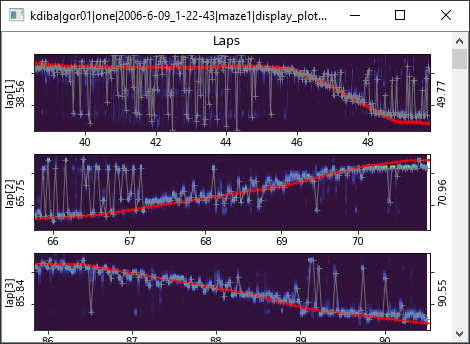
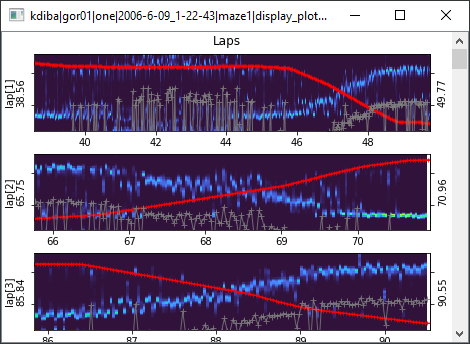

2D is left, 1D is right. Both for 'maze1' so it's not a re-binning issue.